In [ ]:
pip install talos

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.7 MB/s eta 0:00:00
  Created wheel for chances: filename=chances-0.1.9-py3-none-any.whl size=41606 sha256=05a1f7fbb0649fbea4d9000a861f23e8e81cb9c36e2744f082cda59965757210
  Stored in directory: /root/.cache/pip/wheels/c3/26/2b/8ae098b8e9dd7cc1fd0a9131c0f1efea60d710ff7906bf0ab4
  Created wheel for sklearn: filename=sklearn-0.0.post4-py3-none-any.whl size=2973 sha256=20fb269fee59724cf5ab58bfc67fad485e1ca4e9df3f2e1c82248577ae7ef031
  Stor

In [ ]:
import os
import talos
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import tensorflow as tf
from decimal import Decimal
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from datetime import datetime, timedelta
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



In [ ]:
os.makedirs('plots')

In [ ]:
# SELECT START AND END DATE
start = datetime(2014, 1, 1)
end = datetime(2023, 4, 25)


tckr = 'BTC-USD'

ticker = yf.Ticker(tckr)
df = ticker.history(start=start, 
                    end=end, 
                    interval="1d")

In [ ]:
# CALCULATE PRICE RETURNS AS DAILY PERCENTAGE CHANGE USING pct_change()
df['returns'] = 100 * df.Close.pct_change().dropna()
#This code calculates the percentage change between the current and a prior element in the "Close" column of a pandas DataFrame called "df". 
#The "pct_change()" function is a built-in method in pandas that calculates the percentage change between the current and a prior element in a Series or DataFrame. 
#The "Close" column is likely a column in the DataFrame that contains the closing prices of a financial asset, such as a stock or currency, over a period of time. The percentage change in the closing price can be a useful metric for analyzing the performance of the asset.


In [ ]:
# CALCULATE LOG RETURNS BASED ON ABOVE FORMULA
df['log_returns'] = np.log(df.Close/df.Close.shift(1))

In [ ]:
# DROPPING THE 1ST ROW OF DATA 
# BECAUSE I SHIFTED IT FORWARD TO CALCULATE RETURNS/LOG RETURNS
df.dropna(inplace=True)

In [ ]:
# CREATE A FUNCTION THAT CALCULATE REALIZED VOLATILITY
# FROM SAILY LOG RETURNS
def realized_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval 
    """
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))

In [ ]:
INTERVAL_WINDOW = 30
n_future = 7

# GET BACKWARD LOOKING REALIZED VOLATILITY
df['vol_current'] = df.log_returns.rolling(window=INTERVAL_WINDOW)\
                                   .apply(realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY 
df['vol_future'] = df.log_returns.shift(-n_future)\
                                 .rolling(window=INTERVAL_WINDOW)\
                                 .apply(realized_volatility_daily)

In [ ]:
df = df.drop(['Dividends', 'Stock Splits'], axis=1)

In [ ]:
# DROPPING ALL NaN VALUES
df.dropna(inplace=True)

In [ ]:
# PRE-DETERMINE DESIRED TEST & VALIDATION SIZES
test_size = 300
val_size = 200

# CONVERT TO INDICES
split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

# GET CORRESPONDING DATETIME INDICES FOR EACH SET
train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

In [ ]:
print(f'TRAINING \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'VALIDATION \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'TEST \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

TRAINING 	From: 2014-10-17 00:00:00+00:00 	to: 2021-12-03 00:00:00+00:00 	2605 days
VALIDATION 	From: 2021-12-04 00:00:00+00:00 	to: 2022-06-21 00:00:00+00:00 	200 days
TEST 		From: 2022-06-22 00:00:00+00:00 	to: 2023-04-17 00:00:00+00:00 	300 days


In [ ]:
# SPLIT FORWARD VOLATILITY INTO 3 PARTS 
# (this would be the target)
y_train = df.vol_future[train_idx]
y_val = df.vol_future[val_idx]
y_test = df.vol_future[test_idx]

In [ ]:
# SPLIT CURRENT DAILY REALIZED VOLATILITY INTO 3 PARTS 
# (this would be the input for baseline, random walk, and NN models)
x_train = df.vol_current[train_idx]
x_val = df.vol_current[val_idx]
x_test = df.vol_current[test_idx]

In [ ]:
# SPLIT RETURNS INTO 3 PARTS
# (this would be the input for GARCH models)
r_train = df.returns[train_idx]
r_val = df.returns[val_idx]
r_test = df.returns[test_idx]

In [ ]:
# SPLIT LOG RETURNS INTO 3 PARTS
# (mostly for visualization)
lr_train = df.log_returns[train_idx]
lr_val = df.log_returns[val_idx]
lr_test = df.log_returns[test_idx]

In [ ]:
# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON 
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])

In [ ]:
def transform_volatility_to_scaler(scaler, tf_series):
    '''
    Transform a series to a fitted scaler
    '''
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output

In [ ]:
# INITIATE SCALER
scaler_vol = MinMaxScaler()

# FIT SCALER TO CURRENT VOLATILITY IN TRAINING SET
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [ ]:
# TRANSFORM TRAINING CURRENT & FUTURE VOLATILITIES 
x_train_scaled = transform_volatility_to_scaler(scaler_vol, x_train)
y_train_scaled = transform_volatility_to_scaler(scaler_vol, y_train)

# TRANSFORMING VALIDATION CURRENT & FUTURE VOLATILITIES
x_val_scaled = transform_volatility_to_scaler(scaler_vol, x_val)
y_val_scaled = transform_volatility_to_scaler(scaler_vol, y_val)

# TRANSFORMING TEST CURRENT & FUTURE VOLATILITIES
x_test_scaled = transform_volatility_to_scaler(scaler_vol, x_test)
y_test_scaled = transform_volatility_to_scaler(scaler_vol, y_test)

In [ ]:
# DEFINE ROOT MEAN SQUARED PERCENTAGE ERROR FUNCTION
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output


In [ ]:
# DEFINE ROOT MEAN SQUARED ERROR FUNCTION

def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

In [ ]:
# A FUNCTION THAT LOGS MODEL NAME, RMSE AND RMPSE INTO perf_df
# FOR EASY COMPARISON LATER
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name, 
                                       RMSPE(y_true, y_pred), 
                                       RMSE(y_true, y_pred)]
    return perf_df

In [ ]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(x_val_scaled, color='gray',  ls=':',
                label=f"Scaled Current Daily Volatility")
        
        plt.plot(y_true, color='blue', lw=2, 
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')
        
        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)

## 4. Neural Networks

While GARCH remains the gold standard for volatility prediction within traditional financial institutions, there has been an increasing numbers of professionals and researchers turning to Machine Learning, especially Neural Networks, to gain insights into the financial markets in recent years.

(Reference: **Positional Option Trading** - Euan Sinclair)

Traders' theory of the market being inherently efficient (Efficient Market Hypothesis or EHM) states that share prices reflects all information and consistently outperforming the overall market is impossible. The more efficient a market is, the more random and unpredictable the returns will be, and thus **a perfectly efficient market will be completely unpredictable**. 

There are other arguments against EMH, and ones of the most prominent one is based on **Behavioral Finance**: compared to the human history of 200,000 years, the market has not been around for that long. For example, equity options have only been traded in liquid, transparent market since the CBOE opened in 1973; and the average lifetime of an S&P500 company is approx. 20 years. It means that some psychological tendencies of human beings have 200,000 years of evidence behind them, and that a lot of the movements of the markets that were driven by participants' behaviors will likely repeat itself at a later point. Therefore the market system cannot be totally random, it must have some patterns. Those patterns are extremely difficult to exploit due to the multitude of factors that interact and drive the market. 

It'd be interesting to see how Neural Networks perform compared to the traditional GARCH models.

در حالی که GARCH استاندارد طلایی برای پیش‌بینی نوسانات در موسسات مالی سنتی است، تعداد زیادی از متخصصان و محققان در سال‌های اخیر به یادگیری ماشین، به‌ویژه شبکه‌های عصبی، روی آورده‌اند تا بینشی در مورد بازارهای مالی کسب کنند.

(مرجع: معاملات گزینه موقعیتی - یوان سینکلر)

تئوری معامله گران مبنی بر کارایی ذاتی بازار (فرضیه بازار کارآمد یا EHM) بیان می کند که قیمت سهام منعکس کننده تمام اطلاعات است و عملکرد مداوم نسبت به بازار کلی غیرممکن است. هرچه یک بازار کارآمدتر باشد، بازده تصادفی و غیرقابل پیش بینی تر خواهد بود و بنابراین یک بازار کاملاً کارآمد کاملاً غیرقابل پیش بینی خواهد بود.

استدلال‌های دیگری نیز علیه EMH وجود دارد، و یکی از برجسته‌ترین آنها مبتنی بر امور مالی رفتاری است: در مقایسه با تاریخ 200000 ساله بشر، این بازار برای مدت طولانی وجود نداشته است. به عنوان مثال، از زمان افتتاح CBOE در سال 1973، گزینه های سهام فقط در بازار شفاف و شفاف معامله می شود. و میانگین طول عمر یک شرکت S&P500 تقریباً می باشد. 20 سال. این بدان معناست که برخی از تمایلات روانی انسانها شواهد 200000 ساله در پشت خود دارند و بسیاری از تحرکات بازارها که ناشی از رفتارهای شرکت کنندگان است، احتمالاً در مرحله بعد تکرار خواهد شد. بنابراین سیستم بازار نمی تواند کاملاً تصادفی باشد، باید الگوهایی داشته باشد. بهره برداری از این الگوها به دلیل عوامل متعددی که با هم تعامل دارند و بازار را هدایت می کنند بسیار دشوار است.

جالب است که ببینیم شبکه های عصبی در مقایسه با مدل های سنتی GARCH چگونه عمل می کنند.

In [ ]:
# CONVERT AN SERIES TO MATRIX DATASET
def windowed_dataset(x_series, y_series, lookback_window):
    dataX, dataY = [], []
    for i in range((lookback_window-1), len(x_series)):
        start_idx = x_series.index[i-lookback_window+1]
        end_idx = x_series.index[i]
        a = x_series[start_idx:end_idx].values
        dataX.append(a)
        dataY.append(y_series[end_idx])

    return np.array(dataX), np.array(dataY)

In [ ]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays
    that can be used as metrics for NN during training
    '''
    loss = K.sqrt(K.mean(K.square((y_true - y_pred) / y_true)))

    return loss

To generate predictions using Neural Networks, I will use the same sliding window concept again:

![btc_vol_viz%20-%20sliding_forecast_page-0001.jpg](attachment:btc_vol_viz%20-%20sliding_forecast_page-0001.jpg)

This means that to generate future predictions for a time step `t`, I will need to traverse back in time and collect the last `n_past` datapoints (from time step `t - n_past + 1` to `t` inclusively). That's why the shape of the inputs into these Neural Networks need to be **`[batch_size, n_past, 1]`**.

In [ ]:
#for forcast on validation or test set
def forecast(model, range_idx):
    
    start_idx = range_idx[0] - timedelta(n_past - 1)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(df.vol_current[start_idx:end_idx], 
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

In [ ]:
def scale(scaler, y_series):
    scaled = pd.Series(scaler.transform(y_series.values.reshape(-1,1))[:, 0],
                       index=y_series.index)
    return scaled

In [ ]:
def viz_train_val_metrics(model_hist):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(15,6))

        # PLOT MSE - LEFT Y-AXIS
        # TRAINING
        ln11 = ax.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['loss'], color='lightblue',
                    label='Training MSE', lw=2)
        # VALIDATION
        ln12 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_loss'], color='darkblue',
                    label='Validation MSE', lw=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')

        # PLOT RMSE - RIGHT Y-AXIS
        ax2 = ax.twinx()
        ln21 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['rmspe'], color='pink', lw=2,
                    label='Training RMSPE')
        ln22 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['val_rmspe'], color='red', lw=2,
                    label='Validation RMSPE')
        ax2.set_ylabel('RMSPE')

        # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
        lns = ln11 + ln12 + ln21 + ln22
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

        ax.set_title('Training vs. Validation Learning Curves')
        plt.show();

### 4.1. Neural Network Baseline Metrics - Fully Connected Network**

This is essentially Linear Regression.

(Training directly using scaled volatility produces `inf` RMSPE, so I'll stick with the original volatility, and scale the forecasts later).

I will start with using a lookback window `n_past` of 14, and then gradually adjust that value based on the outcomes of my models.

In [ ]:
seed = 666

In [ ]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

snn_1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[n_past, 1]),                          
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

snn_1.compile(loss='mse', 
              optimizer='adam', 
              metrics=[rmspe])

print(snn_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 14)                0         
                                                                 
 dense (Dense)               (None, 1)                 15        
                                                                 
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# FIT MODEL TO TRAINING DATASET 
snn_1_res = snn_1.fit(mat_X_train, mat_y_train, epochs=20,
                      validation_split=0.2,
                      verbose=0, batch_size=batch_size, 
                      shuffle=True)

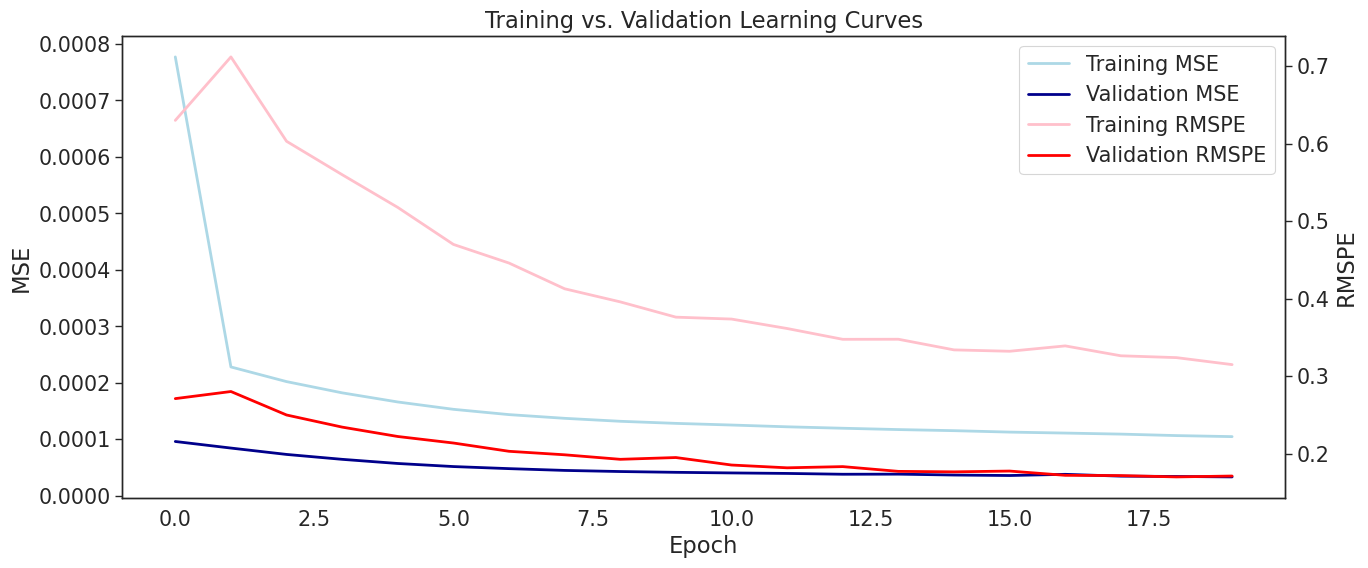

<Figure size 640x480 with 0 Axes>

In [ ]:
viz_train_val_metrics(snn_1_res)
plt.savefig('plots/plot1_linear_regression_training_curves')

In [ ]:
# FORECASTING ON VALIDATION SET
snn_1_preds = forecast(snn_1, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
snn_1_preds_scaled = scale(scaler_vol, snn_1_preds)

7/7 [==============================] - 0s 2ms/step


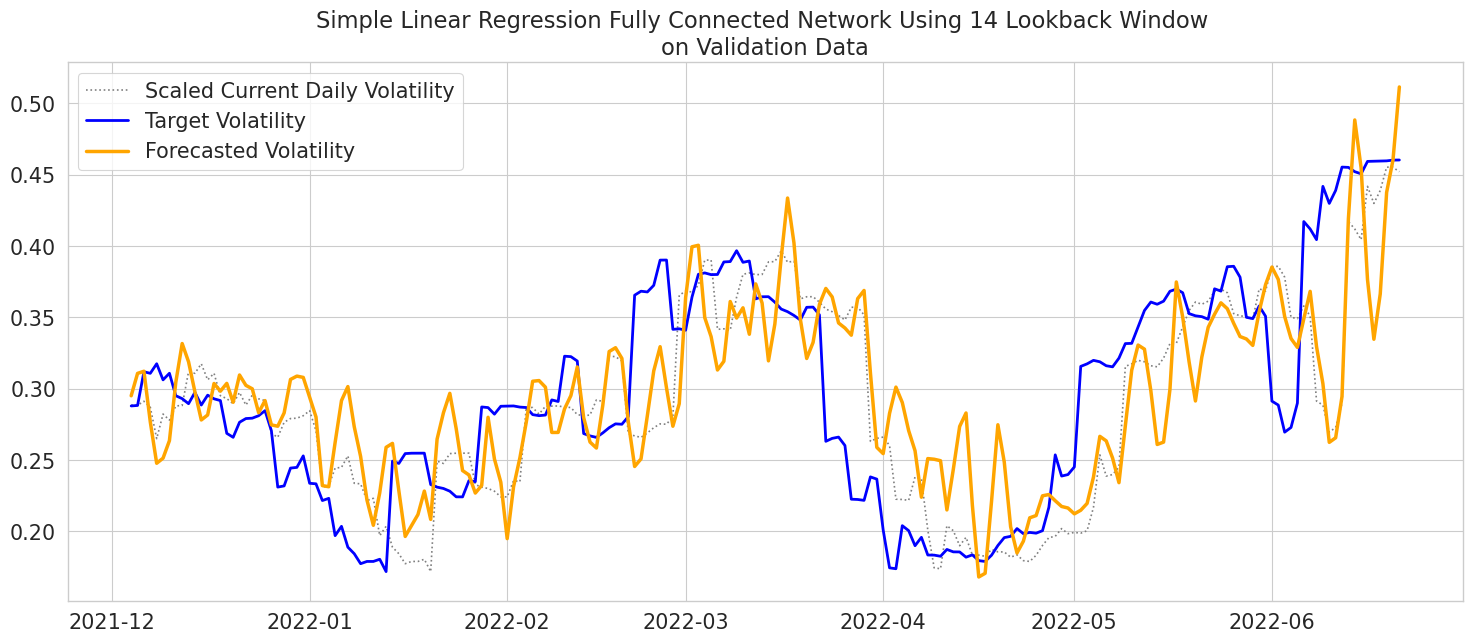

<Figure size 640x480 with 0 Axes>

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, snn_1_preds_scaled, 
          f"Simple Linear Regression Fully Connected Network Using {n_past} Lookback Window")
plt.show();
plt.savefig('plots/plot2_linear_regression_forecasted_validation')

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, snn_1_preds_scaled,
         f"Simple LR Fully Connected NN, n_past={n_past}")

Model  Validation RMSPE  Validation RMSE
0  Simple LR Fully Connected NN, n_past=30          0.224265         0.059308

A simple Fully Connected NN doesn't perform too bad. Validation RMSPE after 100 epochs of training and barely any tuning is already only a bit higher than best TARCH(1,2) model's RMSPE, and actually lower on RMSE.

### 4.2. Univariate Long Short-Term Memory (LSTM)**

(Reference: Geron (2019)

There's a class of Neural Networks called **Recurrent Neural Networks (RNN)** that can "predict the future". RNN works well with time series data, such as stock prices, and can even process sentences, documents, audio samples as inputs. Another application of RNN is in autonomic driving systems, where they're used to anticipate vehicle trajectories and help avoid accidents.

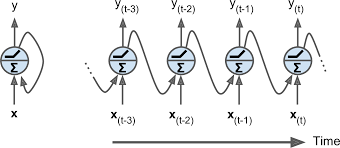

At each time step `t`, the recurrent neuron receives input $x_{t}$ as well as its own output from the previous time step $y_{t-1}$. Since the output of a Recurrent Neuron is a function of all the inputs from the previous time steps, it has a form of *memory* and able to preserve some information through time.

However, due to some transformations that the data goes through when traversing down RNN, some information is lost at each time step, and for a long sequence, the RNN's state contains virtually no information from the first inputs. 

**Long Short-Term Memory (LSTM)** was proposed in 1997 by Sepp Hochreiter and Jurgen Schmidhuber. The key part of LSTM is that the network can learn what's important and needs to be stored in the long-term state, and what can be ignored. LSTM looks very similar to a regular RNN cell, but its state is split into 2 vectors:
- $h_{t}$ - for short term state
- $c_{t}$ - for long term state

LSTM is a black box, and can be used like a basic Recurrent Neural Network (RNN) cell. However, it tends to perform much better, helps training converge faster, and also detect long-term dependencies in the data.

LSTM uses an **optimized implementation when running on a GPU**, that's why it's highly recommended to run this second part of the notebook on **Google Colab**.


In [ ]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_1 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(20),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_1.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_1.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# FIT TO TRAINING DATA
lstm_1_res = lstm_1.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=20)

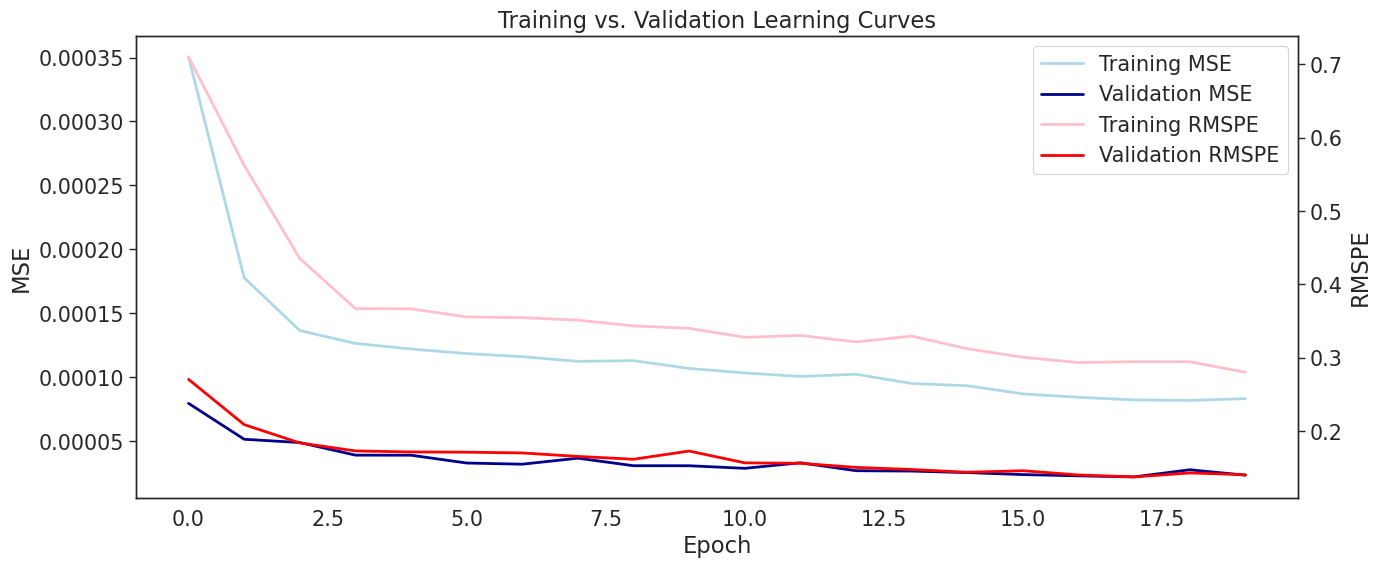

<Figure size 640x480 with 0 Axes>

In [ ]:
# VISUALIZE TRAINING VS. VALIDATION LOSS METRICS
viz_train_val_metrics(lstm_1_res)
plt.savefig('plots/plot3_lstm_1_training_curves')

Validation RMSPE is actually lower than Training RMSPE, but overall all the lines except for Training MSE look quite unstable.

In [ ]:
# FORECASTING ON VALIDATION SET
lstm_1_preds = forecast(lstm_1, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_1_preds_scaled = scale(scaler_vol, lstm_1_preds)

7/7 [==============================] - 1s 4ms/step


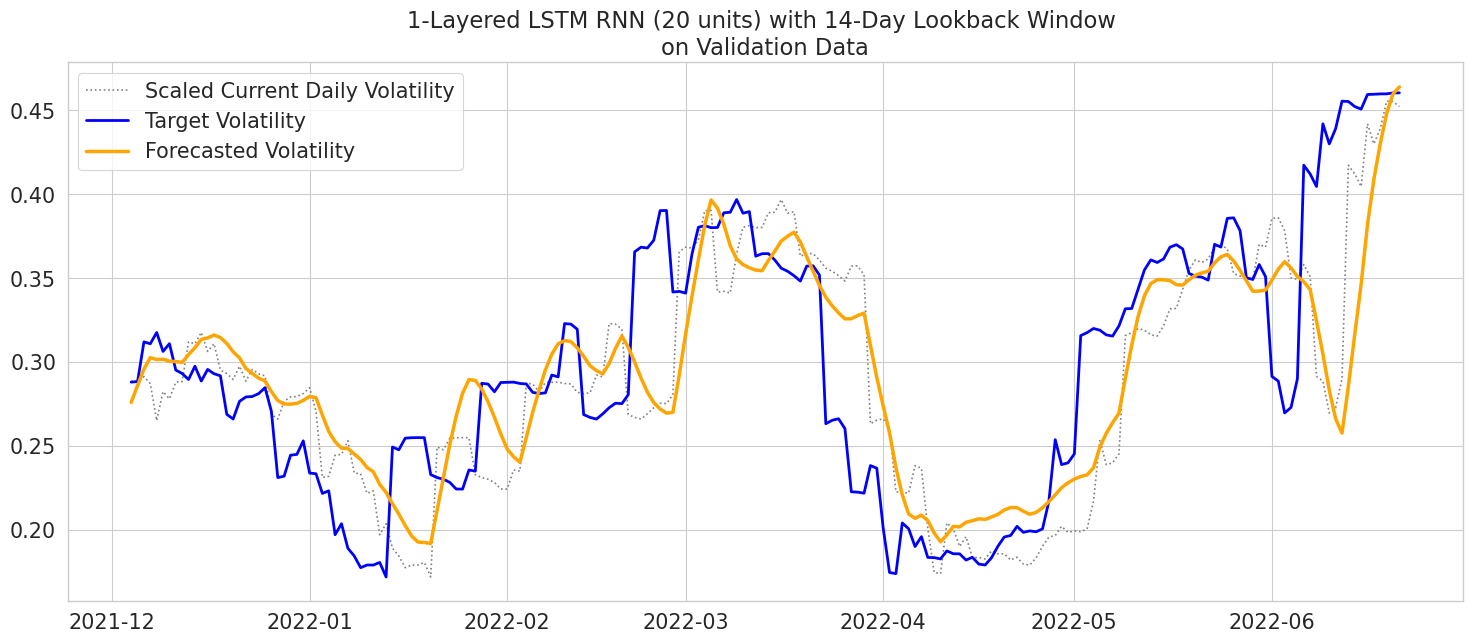

<Figure size 640x480 with 0 Axes>

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_1_preds_scaled, 
          f"1-Layered LSTM RNN (20 units) with {n_past}-Day Lookback Window")
plt.show();
plt.savefig('plots/plot4_lstm_1_forcasted_validation')

Again, predictions traces `vol_current` quite closely, and the prediction line has smoothed out compared to the fully connected NN's predictions (meaning it's less noisy), but it is still also lagging behind compared to desired target.

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_1_preds_scaled, 
         f"LSTM 1 layer 20 units, n_past={n_past}")

Model  Validation RMSPE  Validation RMSE
0  Simple LR Fully Connected NN, n_past=30          0.224265         0.059308
1         LSTM 1 layer 20 units, n_past=30          0.172286         0.050687

Simple 1-layered LSTM is only a tiny bit better than fully connected network on RMSPE, and actually has higher RMSE than the simple LR NN above.

### 4.3. Univariate Bidirectional LSTM

(Reference: https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/#:~:text=Bidirectional%20LSTMs%20are%20an%20extension,LSTMs%20on%20the%20input%20sequence)

Further research shows that there's an extension of LSTM cell called **Bidirectional LSTM**, which could potentially be better in this case by providing additional context to the models. Since all timesteps of the input sequence are already available, Bidirectional LSTM could train 2 instead of 1 LSTMs on the same input sequence:
- 1st one on the inputs as-is
- 2nd one on the reversed copy of the inputs

This could help provide additional context to the networks, and usually produces faster and fuller learning on the problem.

LSTM allows the maintenance of certain long-term memories across time, thereofore I'll extend `n_past` to 1 month, and also increase the number of hidden layers to see if the model can capture certain patterns better.

In [ ]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

# INCREASING LOOKBACK WINDOW TO 1 MONTH
n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_2 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_2.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_2.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 19,105
Trainable params: 19,105
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# FITTING lstm_2 TO TRAINING DATA
lstm_2_res = lstm_2.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=20)

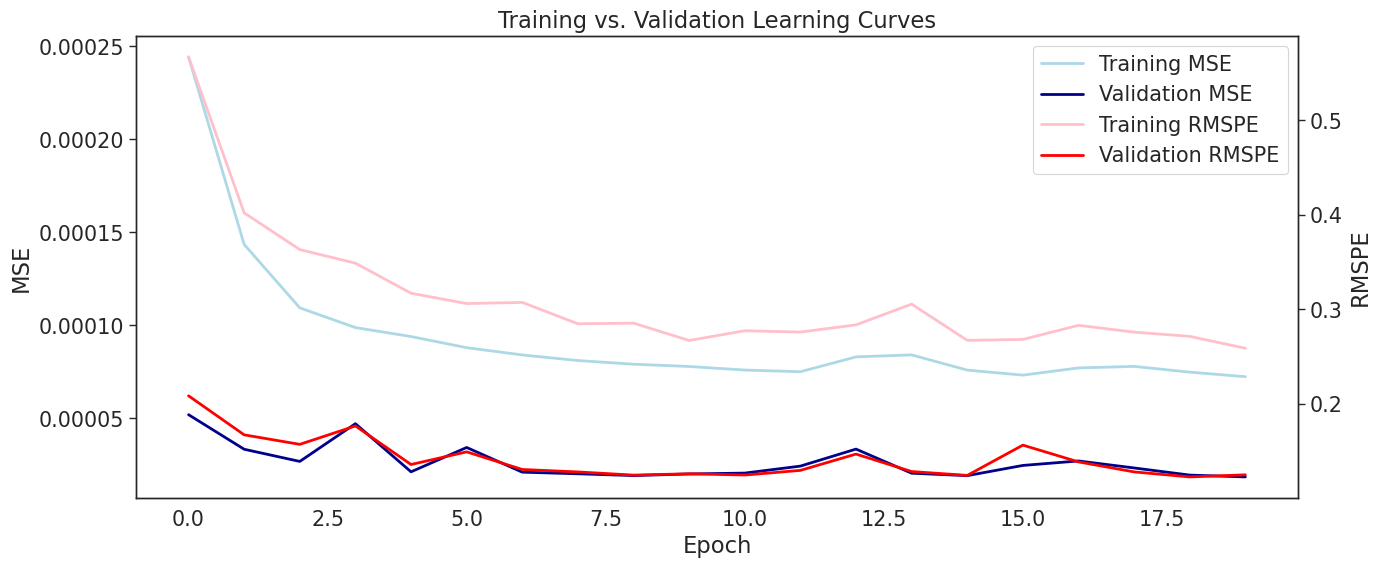

<Figure size 640x480 with 0 Axes>

In [ ]:
# VISUALIZING PERFORMANCE METRICS
viz_train_val_metrics(lstm_2_res)
plt.savefig('plots/plot5_lstm_2_training_curves')

In [ ]:
# FORECASTING ON VALIDATION SET
lstm_2_preds = forecast(lstm_2, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_2_preds_scaled = scale(scaler_vol, lstm_2_preds) 

7/7 [==============================] - 2s 15ms/step


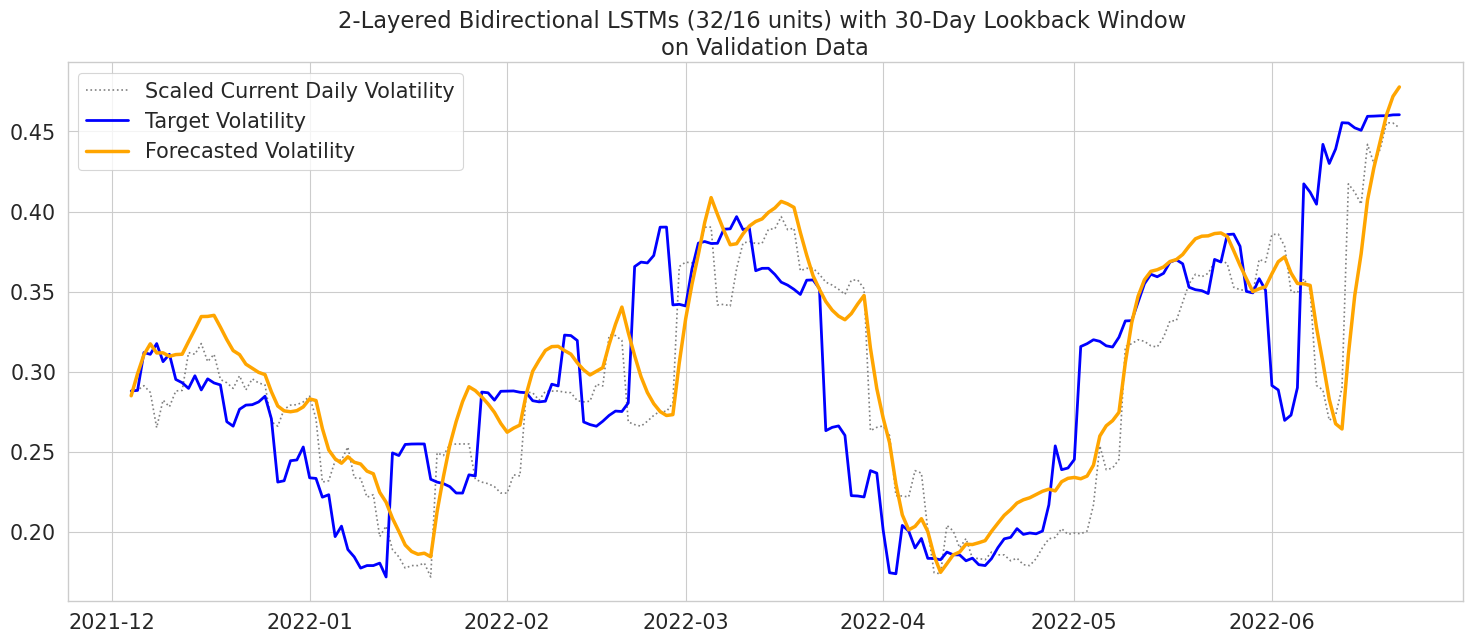

<Figure size 640x480 with 0 Axes>

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_2_preds_scaled, 
          f"2-Layered Bidirectional LSTMs (32/16 units) with {n_past}-Day Lookback Window")

plt.show();
plt.savefig('plots/plot6_lstm2_forecasted_validation')

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_2_preds_scaled, 
         f"2 layers Bidirect LSTM (32/16 units), n_past={n_past}")

Model  Validation RMSPE  \
0          Simple LR Fully Connected NN, n_past=30          0.224265   
1                 LSTM 1 layer 20 units, n_past=30          0.172286   
2  2 layers Bidirect LSTM (32/16 units), n_past=30          0.175937   

   Validation RMSE  
0         0.059308  
1         0.050687  
2         0.050617

2 Layered Bidirectional LSTMs with a lookback window of 30 days has managed to beat the best GARCH model (TARCH(2,2)) found above, which means I'm probably heading in the right direction!

In my other Exploratory Notebooks I have experimented with different activation functions and network structures, such as:
- using `activation='relu'` or `activation='sigmoid'`
- increasing the number of hidden LSTM layers
- increasing number of units in each LSTM layer
- adding in Dropout layer with different dropout percentage
- changing `batch_size`

However, none of them have outperform the simple architecture above (2 layers of Bidirectional LSTMs with 32 and 16 units, and `n_past=30`). 

### 4.4. Univariate Bidirectional LSTM + 1D Convolutional Layer(s)

(Reference: Geron (2019))

A 1D convolutional layer slides several kernels across a sequence, producing a 1D feature map per kernel. Each kernel will learn to detect a single very short sequential pattern (no longer than the kernel size). 

Convolutional layers are supposed to allow lookback window extension, and help the model pick up patterns further in the past.

In [ ]:
# Ref: https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/supplement/DM4fi/convolutional-neural-networks-course

# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_3 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),
    # ADDING 1D CONVOLUTIONAL LAYER 
    tf.keras.layers.Conv1D(filters=32, kernel_size=4,
                           # DOWNSAMPLE INPUT SEQUENCE BY A FACTOR OF 2
                           strides=2, padding="valid",    
                           activation="relu",
                           input_shape=[None, 1]),                            
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu',
                                                       return_sequences=True)),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_3.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_3.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')
print(lstm_3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 conv1d (Conv1D)             (None, None, 32)          160       
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         16640     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 27,201
Trainable params: 27,201
Non-traina

In [ ]:
# FITTING MODEL TO TRAINING DATA
lstm_3_res = lstm_3.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=20)

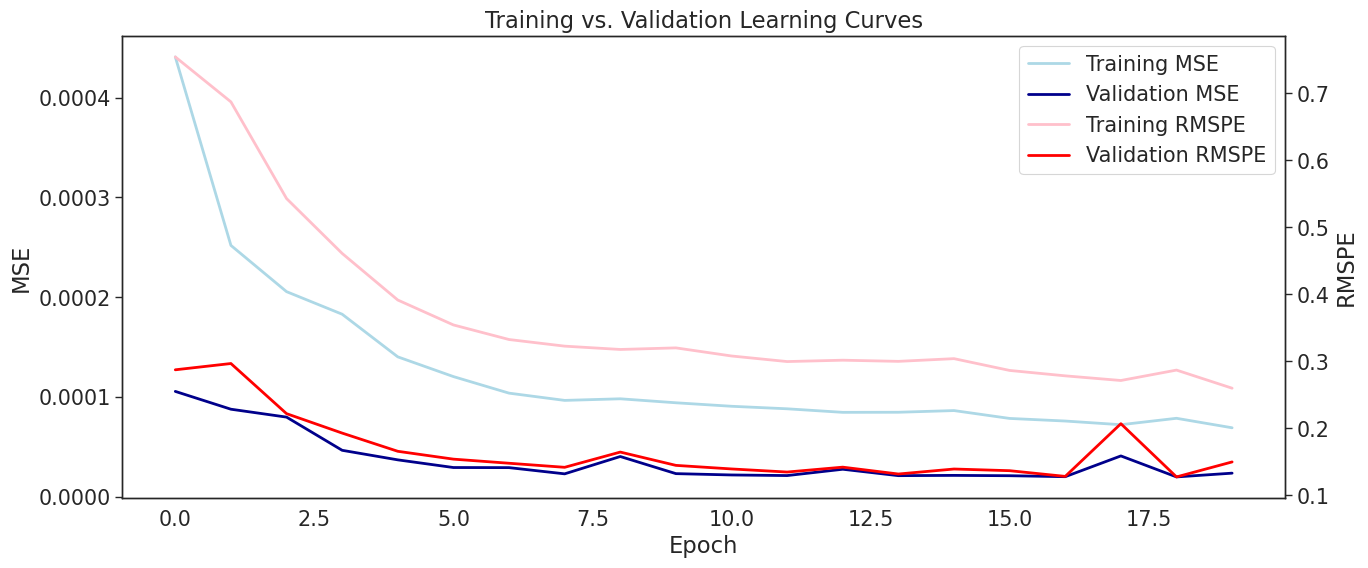

<Figure size 640x480 with 0 Axes>

In [ ]:
# VISUALIZING TRAINING/VALIDATION METRICS
viz_train_val_metrics(lstm_3_res)
plt.savefig('plots/plot7_lstm_3_training_curves')

In [ ]:
# FORECASTING ON VALIDATION SET
lstm_3_preds = forecast(lstm_3, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_3_preds_scaled = scale(scaler_vol, lstm_3_preds)

7/7 [==============================] - 1s 7ms/step


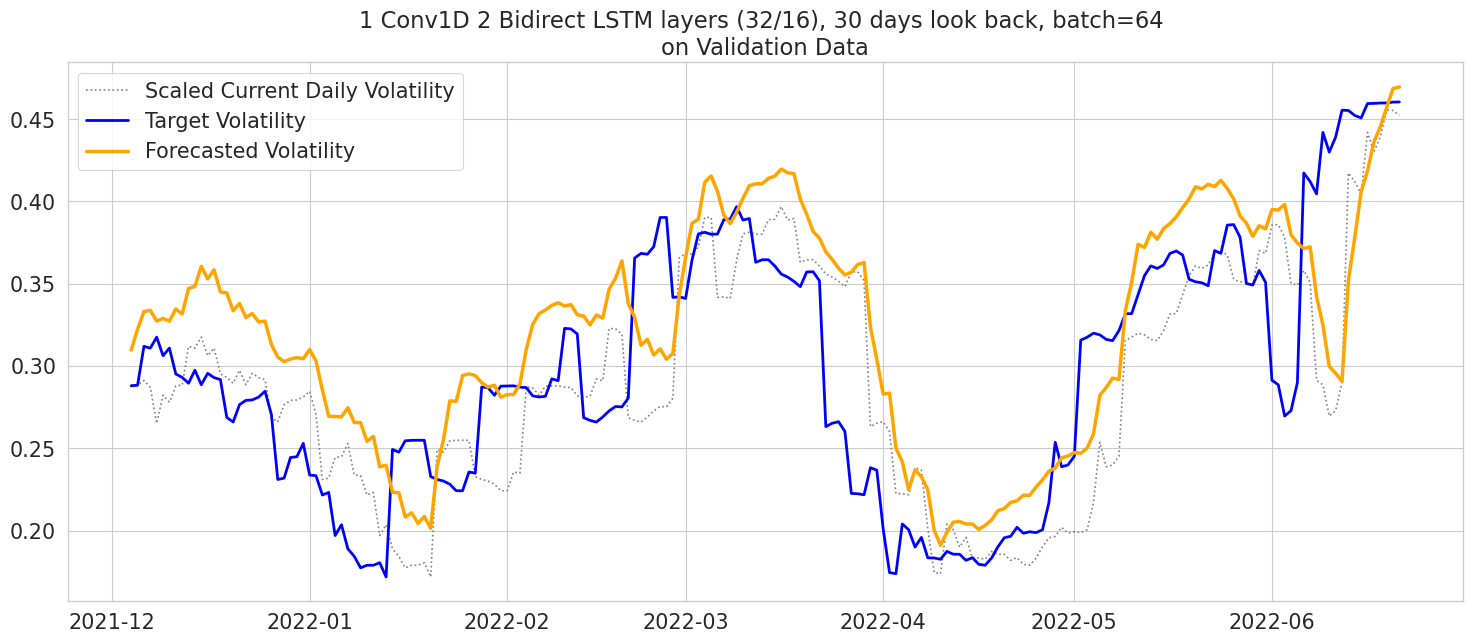

<Figure size 640x480 with 0 Axes>

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_3_preds_scaled, 
          f"1 Conv1D 2 Bidirect LSTM layers (32/16), {n_past} days look back, batch={batch_size}")

plt.show();
plt.savefig('plots/plot8_lstm_3_forecasted_validation')

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_3_preds_scaled, 
         f"1 Conv1D 2 Bidirect LSTM layers (32/16), n_past={n_past}, batch={batch_size}")

Model  Validation RMSPE  \
0            Simple LR Fully Connected NN, n_past=30          0.224265   
1                   LSTM 1 layer 20 units, n_past=30          0.172286   
2    2 layers Bidirect LSTM (32/16 units), n_past=30          0.175937   
3  1 Conv1D 2 Bidirect LSTM layers (32/16), n_pas...          0.214646   

   Validation RMSE  
0         0.059308  
1         0.050687  
2         0.050617  
3         0.056291

So Convolutional layers aren't really helping much here. Both RMSPE and RMSE have gone up substantially, and the performance is somewhat on par with simple LR fully connected NN. 

(Reference: Geron (2019))

In my other Exploratory Notebooks I have also experimented with a simplified version of **WaveNet**, an architecture proposed by Aaron van den Oord and other DeepMind researchers in 2016.

![WaveNet architecture](https://paperswithcode.com/media/methods/Screen_Shot_2020-05-24_at_12.11.35_AM_uO4kv1I.png)

WaveNet was created by stacking 1D convolutional layers on top of each other, doubling dilation rate at each layer (dilation rate represents the distance between each neuron's inputs or how spread apart each neuron's inputs are). That way:
- the lower layers learn short-term patterns
- and the higher layers can learn long-term patterns

WaveNet works very well with extremely large sequences, especially audio samples (hence the name), but it's also been found to be very successful with financial time series data in which "significant" events are usually sporadic and rare (meaning the time periods between those events tend to vary).

My version of WaveNet wasn't very successful at picking up more subtle changes in volatility. I honestly don't think this architecture is not good, it's more likely I haven't figured out how to properly implement it in a way that's suitable for my dataset. This would definitely be one of the potential ideas to further explore in the future.


بنابراین لایه‌های Convolutional واقعاً در اینجا کمک زیادی نمی‌کنند. هر دو RMSPE و RMSE به طور قابل توجهی افزایش یافته اند و عملکرد تا حدودی با NN ساده LR کاملاً متصل است.

(مرجع: Geron (2019))

در دیگر نوت‌بوک‌های اکتشافی خود، نسخه ساده‌شده WaveNet را نیز آزمایش کرده‌ام، معماری پیشنهادی Aaron van den Oord و دیگر محققان DeepMind در سال 2016.

معماری WaveNet

WaveNet با چیدن لایه‌های کانولوشنیک 1 بعدی روی یکدیگر، دو برابر شدن سرعت اتساع در هر لایه ایجاد شد (نرخ اتساع نشان‌دهنده فاصله بین ورودی‌های هر نورون یا میزان پراکندگی ورودی‌های هر نورون است). به این ترتیب:

لایه های پایین الگوهای کوتاه مدت را یاد می گیرند
و لایه های بالاتر می توانند الگوهای بلند مدت را یاد بگیرند
WaveNet با توالی‌های بسیار بزرگ، به‌ویژه نمونه‌های صوتی (از این رو نام آن) بسیار خوب کار می‌کند، اما همچنین مشخص شده است که با داده‌های سری زمانی مالی که در آن رویدادهای «مهم» معمولاً پراکنده و نادر هستند (به معنای دوره‌های زمانی بین آن‌ها) بسیار موفق عمل می‌کند. رویدادها تمایل دارند متفاوت باشند).

نسخه من از WaveNet در برداشتن تغییرات ظریف تر در نوسانات چندان موفق نبود. من صادقانه فکر نمی کنم این معماری خوب نیست، به احتمال زیاد متوجه نشده ام که چگونه آن را به روشی مناسب برای مجموعه داده ام پیاده سازی کنم. این قطعاً یکی از ایده‌های بالقوه برای بررسی بیشتر در آینده خواهد بود.

### 4.5. Learning Rate Tuning with SGD Optimizer

So far I have only used the standard `adam` optimizer. It'd be interesting to see how the model performs on a more customizable optimizer like **Stochastic Gradient Descent (SGD)**. I will continue this with the most successful LSTM architecture so far (2 layers of Bidirectional LSTMs with 32 and 16 units and a lookback window of 30 days).

In [ ]:
# Ref: https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/supplement/DM4fi/convolutional-neural-networks-course

# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_4 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

# EXPONENTIALLY INCREASE LEARNING RATE 
# BY THE POWER OF 10 EVERY 20 EPOCHS
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
lstm_4.compile(loss='mse',
               optimizer=optimizer,
               metrics=[rmspe])

lstm_4_res = lstm_4.fit(mat_X_train, mat_y_train, epochs=20,
                        callbacks=[lr_schedule],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

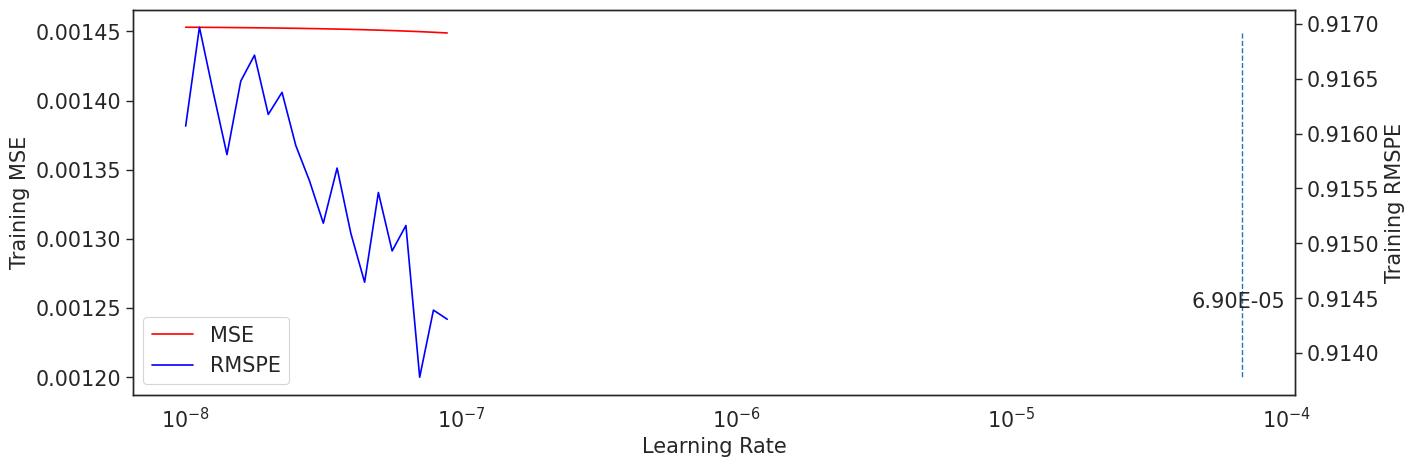

In [ ]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(15,5))

    # PLOT MSE - LEFT Y-AXIS
    ln1 = ax.semilogx(lstm_4_res.history['lr'], lstm_4_res.history['loss'], 
                color='red', label='MSE')
    ax.set_xlabel('Learning Rate', fontsize=15)
    ax.set_ylabel('Training MSE', fontsize=15)

    # PLOT RMSE - RIGHT Y-AXIS
    ax2 = ax.twinx()
    ln2 = ax2.semilogx(lstm_4_res.history['lr'], lstm_4_res.history['rmspe'],
                color='blue', label='RMSPE')
    ax2.set_ylabel('Training RMSPE', fontsize=15)

    # COMBINING LALBELS FOR 2 LINES INTO 1 LEGEND
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='lower left')

    best_lr = 6.9e-5

    ax.vlines(x=best_lr, ls='--', lw=1,
            ymin=np.min(lstm_4_res.history["loss"]),
            ymax=0.0012)

    ax.text(4.5e-5, 0.00125, '%.2E' % Decimal(best_lr), fontsize=15)

    plt.show();

The best learning rate would likely be `6.9e-5` which is the intersection between the RMSE and RMSPE lines. RMSE continues to go down even when Learning Rate approaches `1e-1`, but RMSPE started going up around `4e-5` and gets very unstable quickly after. Next I am going to re-train the model using the best learning rate found above.

In [ ]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_4 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=best_lr, momentum=0.9)
lstm_4.compile(loss='mse',
               optimizer=optimizer,
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_4.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_4_res = lstm_4.fit(mat_X_train, mat_y_train, epochs=20,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

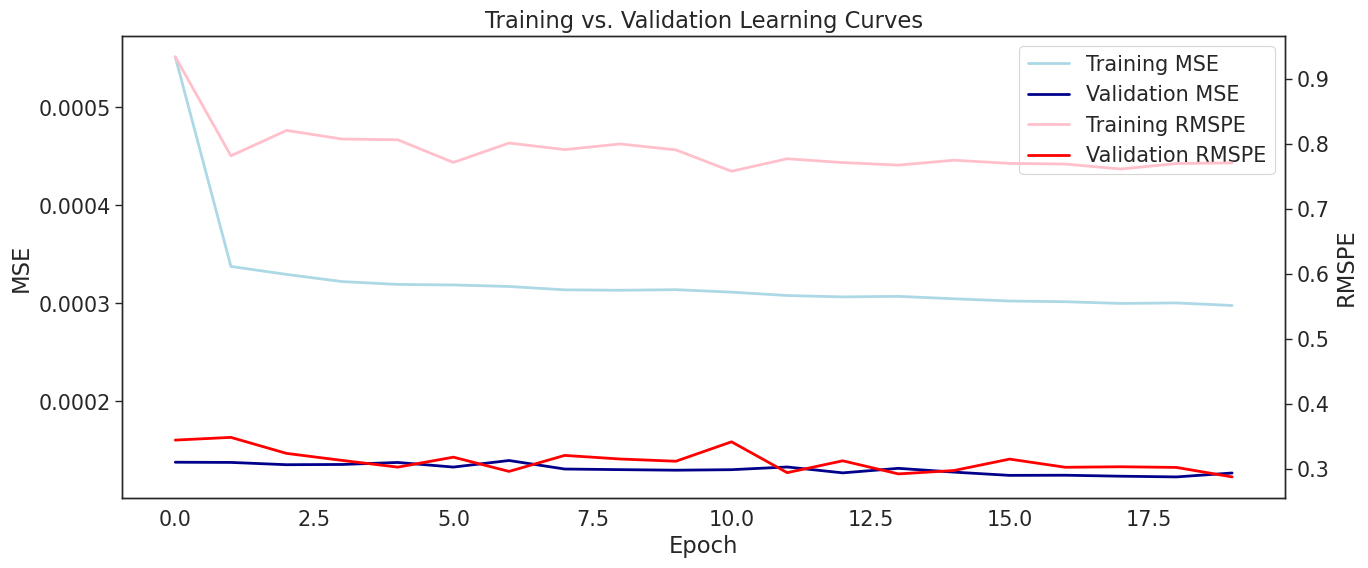

<Figure size 640x480 with 0 Axes>

In [ ]:
# VISUALIZING TRAINING/VALIDATION LEARNING CURVES
viz_train_val_metrics(lstm_4_res)
plt.savefig('plots/plot9_lstm4_training_curves')

Training RMSPE started going up after epoch 5, but surprisingly everything else (including Validation RMSPE) continues to go down until epoch 35 where performance stopped progressing.

In [ ]:
# FORECASTING ON VALIDATION SET
lstm_4_preds = forecast(lstm_4, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_4_preds_scaled = scale(scaler_vol, lstm_4_preds)

7/7 [==============================] - 2s 16ms/step


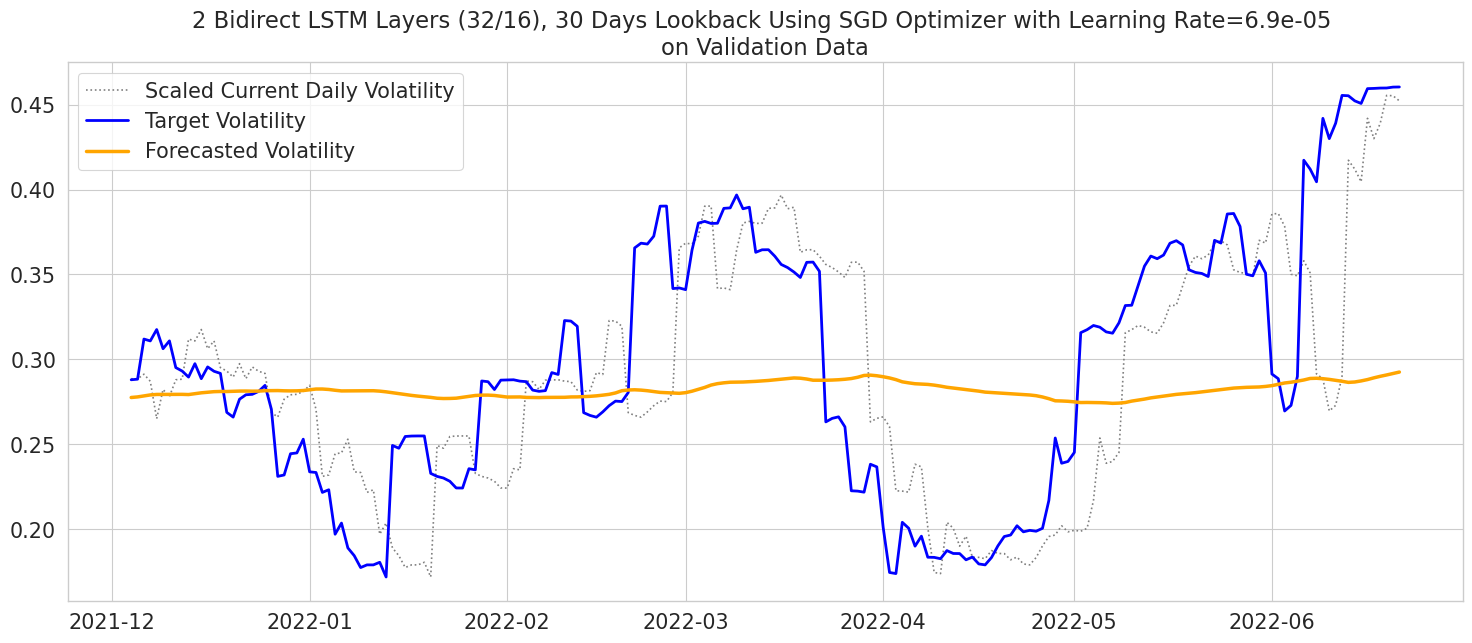

<Figure size 640x480 with 0 Axes>

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_4_preds_scaled, 
          f"2 Bidirect LSTM Layers (32/16), {n_past} Days Lookback Using SGD Optimizer with Learning Rate={best_lr}")
plt.show();
plt.savefig('plots/plot10_lstm4_forecasted_validation')

This customized optimizer seems to prioritize volatility's long-term tendency to revert to the mean. Hence the predictions hovers where the mean is.

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_4_preds_scaled, 
         f"2 Bidirect LSTMs (32/16), n_past={n_past}, batch={batch_size}, SGD lr={best_lr}")

Model  Validation RMSPE  \
0            Simple LR Fully Connected NN, n_past=30          0.224265   
1                   LSTM 1 layer 20 units, n_past=30          0.172286   
2    2 layers Bidirect LSTM (32/16 units), n_past=30          0.175937   
3  1 Conv1D 2 Bidirect LSTM layers (32/16), n_pas...          0.214646   
4  2 Bidirect LSTMs (32/16), n_past=30, batch=64,...          0.276782   

   Validation RMSE  
0         0.059308  
1         0.050687  
2         0.050617  
3         0.056291  
4         0.076506

The settings for SGD optimizer using best learning rate found above did not seem to yield better results than the `adam` optimizer, so going forward I will stick with `adam`.

### 4.6. Multivariate LSTM

So far I have only using simple 1-dimensional inputs for all of my models, and for financial data, this is likely insufficient. That could be the reason why most of the above models seems failed to yield better result than Naive Forecasting. It doesn't matter how many neurons or hidden layers are used, or how complex the model's architectures are, inadequate data is most likely not going to produce good results.

For the next section, I'll attempt to create Multivariate Neural Networks to see if additional features could help improve performance.
تاکنون فقط از ورودی‌های ساده یک بعدی برای همه مدل‌هایم استفاده کرده‌ام، و برای داده‌های مالی، این احتمالاً کافی نیست. این می‌تواند دلیلی باشد که به نظر می‌رسد اکثر مدل‌های فوق نتوانستند نتیجه بهتری نسبت به پیش‌بینی ساده لوح ارائه دهند. مهم نیست که چند نورون یا لایه پنهان استفاده شده است، یا معماری مدل چقدر پیچیده است، داده های ناکافی به احتمال زیاد نتایج خوبی را به همراه نخواهد داشت.

برای بخش بعدی، سعی می کنم شبکه های عصبی چند متغیره ایجاد کنم تا ببینم آیا ویژگی های اضافی می تواند به بهبود عملکرد کمک کند یا خیر.

In [ ]:
df.head()

Open        High         Low       Close  \
Date                                                                        
2014-10-17 00:00:00+00:00  382.756012  385.477997  375.389008  383.757996   
2014-10-18 00:00:00+00:00  383.976013  395.157990  378.971008  391.441986   
2014-10-19 00:00:00+00:00  391.253998  393.938995  386.457001  389.545990   
2014-10-20 00:00:00+00:00  389.230988  390.084015  378.252014  382.845001   
2014-10-21 00:00:00+00:00  382.420990  392.645996  380.834015  386.475006   

                             Volume   returns  log_returns  vol_current  \
Date                                                                      
2014-10-17 00:00:00+00:00  13600700  0.314201     0.003137     0.039872   
2014-10-18 00:00:00+00:00  11416800  2.002301     0.019825     0.037566   
2014-10-19 00:00:00+00:00   5914570 -0.484362    -0.004855     0.035089   
2014-10-20 00:00:00+00:00  16419000 -1.720205    -0.017352     0.034629   
2014-10-21 00:00:00+00:00  14188900  0.948166     0.009437     0.034362   

                           vol_future  
Date                                   
2014-10-17 00:00:00+00:00    0.032900  
2014-10-18 00:00:00+00:00    0.033009  
2014-10-19 00:00:00+00:00    0.033083  
2014-10-20 00:00:00+00:00    0.033017  
2014-10-21 00:00:00+00:00    0.031334

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3090 entries, 2014-10-17 00:00:00+00:00 to 2023-04-02 00:00:00+00:00
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         3090 non-null   float64
 1   High         3090 non-null   float64
 2   Low          3090 non-null   float64
 3   Close        3090 non-null   float64
 4   Volume       3090 non-null   int64  
 5   returns      3090 non-null   float64
 6   log_returns  3090 non-null   float64
 7   vol_current  3090 non-null   float64
 8   vol_future   3090 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 305.9 KB


In [ ]:
df.describe()

Open          High           Low         Close        Volume  \
count   3090.000000   3090.000000   3090.000000   3090.000000  3.090000e+03   
mean   13277.557994  13609.922742  12911.824212  13285.011811  1.676682e+10   
std    16076.753134  16486.960628  15605.784321  16073.835202  1.983081e+10   
min      176.897003    211.731003    171.509995    178.102997  5.914570e+06   
25%      751.844513    764.468491    739.070755    752.768768  1.268932e+08   
50%     7416.254883   7573.982910   7270.244385   7420.971436  9.350333e+09   
75%    19104.568359  19371.561035  18610.712891  19113.286133  2.836630e+10   
max    67549.734375  68789.625000  66382.062500  67566.828125  3.509679e+11   

           returns  log_returns  vol_current   vol_future  
count  3090.000000  3090.000000  3090.000000  3090.000000  
mean      0.212418     0.001392     0.035636     0.035634  
std       3.807574     0.038388     0.016041     0.016041  
min     -37.169539    -0.464730     0.007228     0.007228  
25%      -1.314977    -0.013237     0.025135     0.025135  
50%       0.172909     0.001728     0.033558     0.033545  
75%       1.773968     0.017584     0.044067     0.044067  
max      25.247169     0.225119     0.103878     0.103878

#### 4.6.1. Feature Engineering

The Open/High/Low/Close prices are usually very similar and highly correlated to each other. Therefore, instead of keeping all of them in the dataset, I would add 2 more features:
- **High-Low Spread** - which is the logarithm of the difference between the Highest and Lowest prices intraday as a percentage of the Closing price
- **Open-Close Spread** - which is the difference between the Close and Open prices intraday as a percentage of the Closing price

and then for Volume:
- Volume column has very large values that are billions/millions of times larger than the other features. Therefore I'm going to the get `np.log()` of it, and hopefully transform it into a more normal looking distribution.

and eliminate the three `Close`, `Open`, `High`, `Low` columns.

In [ ]:
df['HL_sprd'] = np.log((df.High - df.Low) / df.Close)
df['CO_sprd'] = (df.Close - df.Open) / df.Open
df['Volume'] = np.log(df.Volume)

In [ ]:
df.head()

Open        High         Low       Close  \
Date                                                                        
2014-10-17 00:00:00+00:00  382.756012  385.477997  375.389008  383.757996   
2014-10-18 00:00:00+00:00  383.976013  395.157990  378.971008  391.441986   
2014-10-19 00:00:00+00:00  391.253998  393.938995  386.457001  389.545990   
2014-10-20 00:00:00+00:00  389.230988  390.084015  378.252014  382.845001   
2014-10-21 00:00:00+00:00  382.420990  392.645996  380.834015  386.475006   

                              Volume   returns  log_returns  vol_current  \
Date                                                                       
2014-10-17 00:00:00+00:00  16.425632  0.314201     0.003137     0.039872   
2014-10-18 00:00:00+00:00  16.250597  2.002301     0.019825     0.037566   
2014-10-19 00:00:00+00:00  15.592929 -0.484362    -0.004855     0.035089   
2014-10-20 00:00:00+00:00  16.613950 -1.720205    -0.017352     0.034629   
2014-10-21 00:00:00+00:00  16.467971  0.948166     0.009437     0.034362   

                           vol_future   HL_sprd   CO_sprd  
Date                                                       
2014-10-17 00:00:00+00:00    0.032900 -3.638567  0.002618  
2014-10-18 00:00:00+00:00    0.033009 -3.185630  0.019444  
2014-10-19 00:00:00+00:00    0.033083 -3.952483 -0.004365  
2014-10-20 00:00:00+00:00    0.033017 -3.476822 -0.016407  
2014-10-21 00:00:00+00:00    0.031334 -3.487953  0.010601

These numeric features will need to be normalized later since LSTM uses `sigmoid` and `tanh` activation functions, which is very sensitive magnitude.

Since `vol_current` is already derived from `log_returns`, I am not going to include `log_returns` in my model.

In [ ]:
features = ['HL_sprd', 'CO_sprd', 'Volume', 'vol_current']

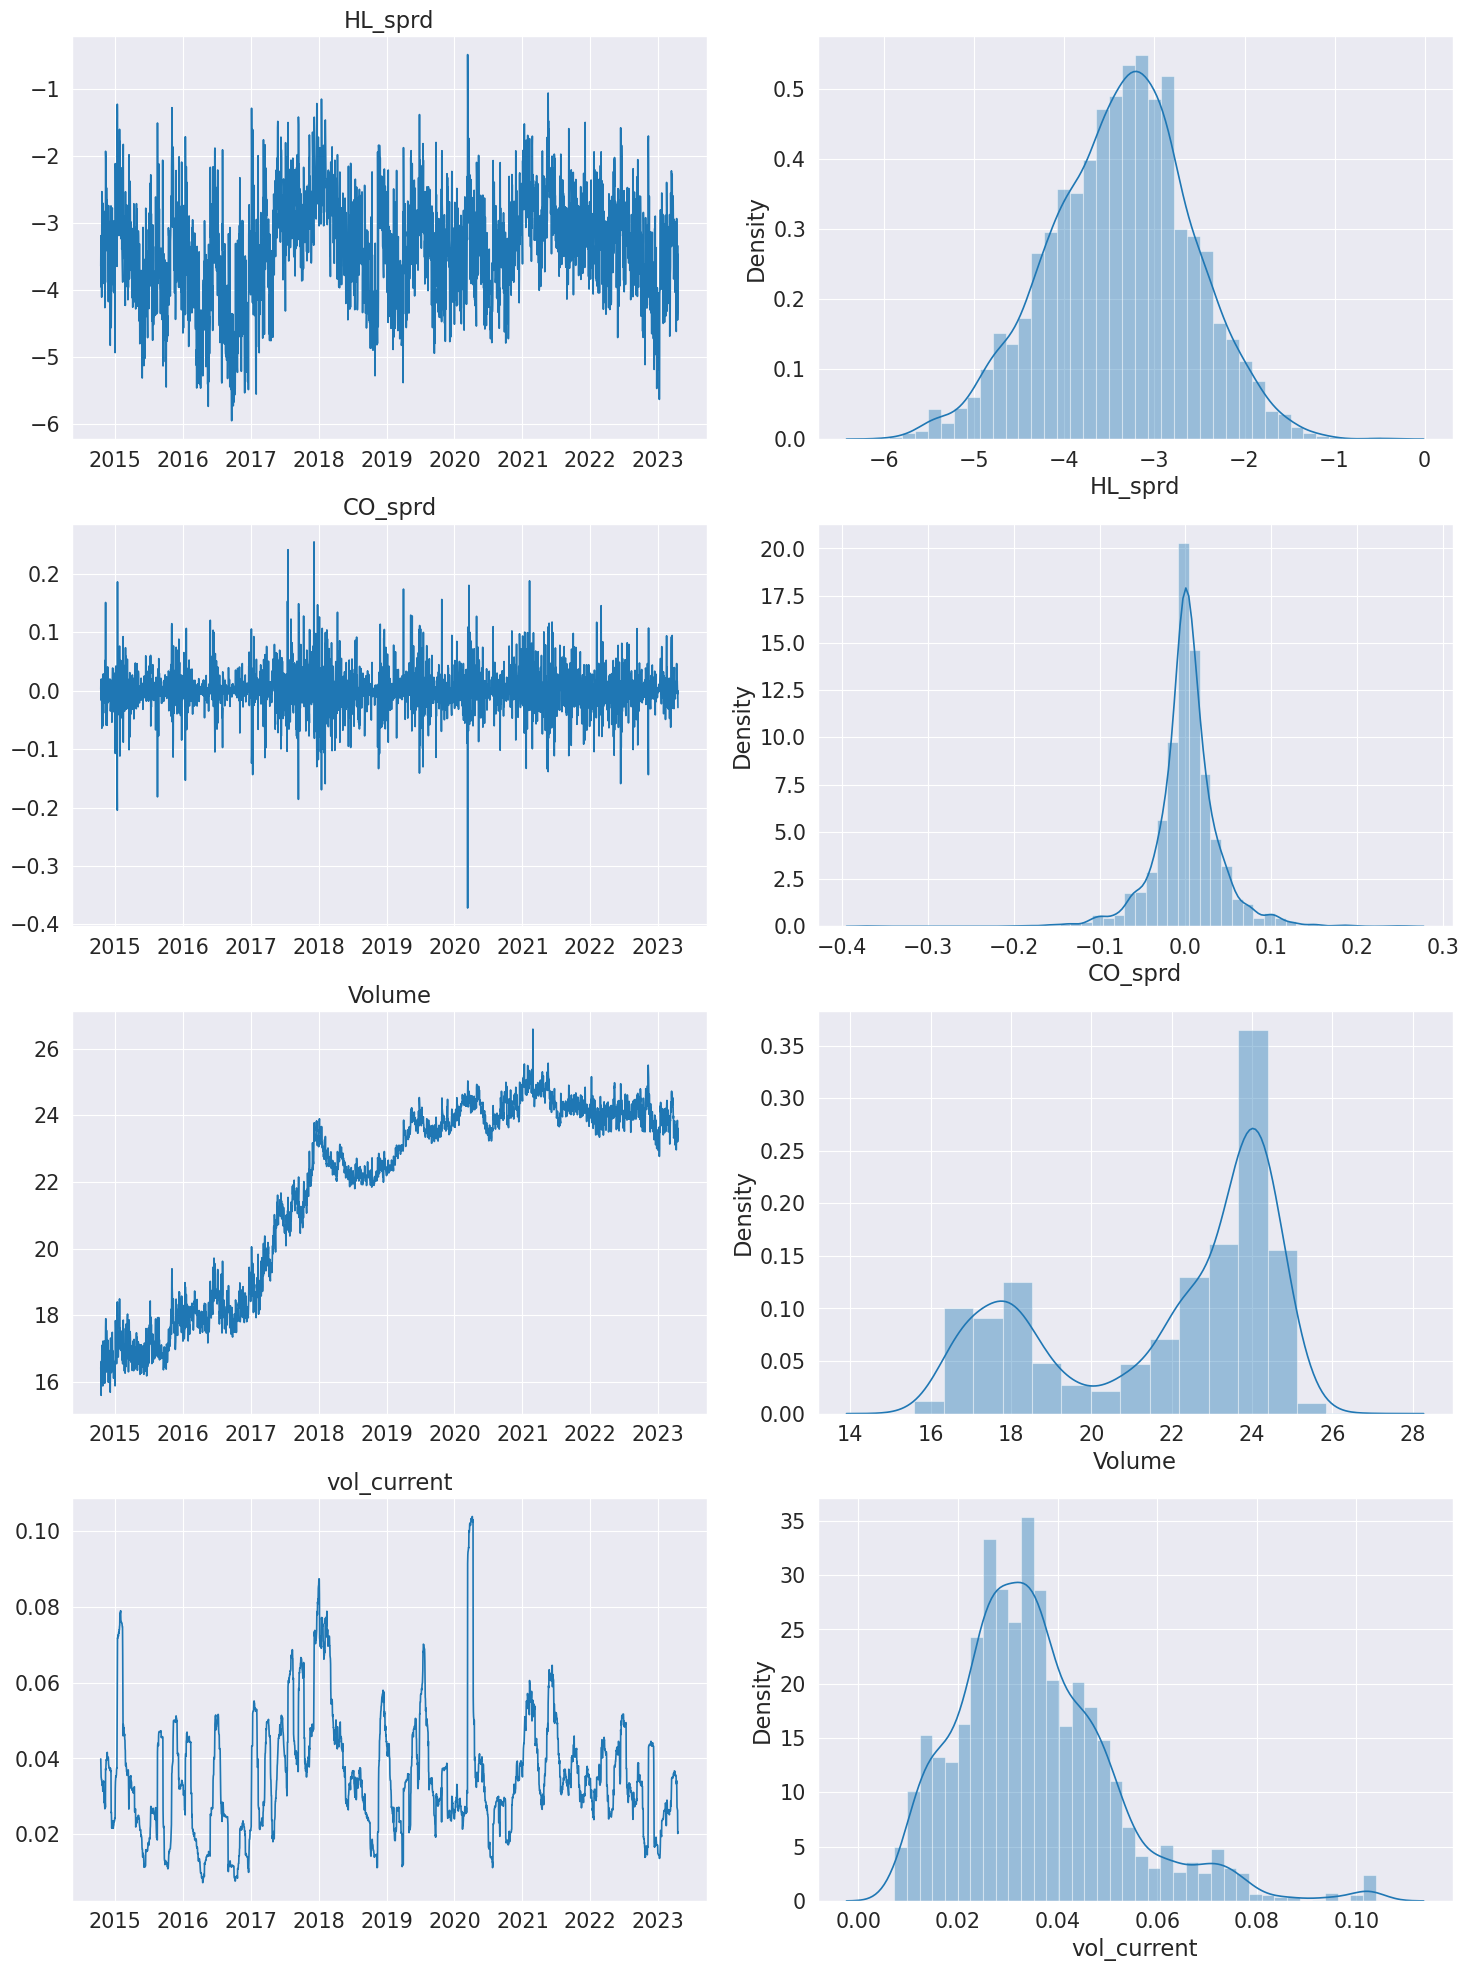

In [ ]:
# PLOT EACH NUMERICAL COLUMN
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,20))

    for i, c in enumerate(features):
        ax1, ax2 = axes[i][0], axes[i][1]
        ax1.plot(df[c])
        ax1.set_title(c)

        sns.distplot(df[c], ax=ax2)

    plt.tight_layout()
    plt.show();

#### 4.6.2. Input Reshaping

The predict here would be to predict next 7 days' volatility (`vol_future`) column using 4 input variables:
1. `HL_sprd`
2. `CO_sprd`
3. `Volume`
4. `vol_current`

Reshaping the inputs is the meat of these Multivariate LSTM. Generally speaking, inputs for LSTM should be in the shape of:


**`[batch_size, n_past, input_dims]`**



in which:

- **`batch_size`** is the number of datapoints in each batch
- **`n_past`** is the number of past time steps to be used for prediction (I'll use the same value as above for now).
- **`input_dims`** is the number of input features (which is 4 in this case)  

In [ ]:
# SEPARATE INPUT DATAFRAME FROM df
input_df = df[features]

# SEPARATE INPUTS FOR TRAINING SET ONLY
X_train = input_df.loc[train_idx]

In [ ]:
X_train.head()

HL_sprd   CO_sprd     Volume  vol_current
Date                                                                 
2014-10-17 00:00:00+00:00 -3.638567  0.002618  16.425632     0.039872
2014-10-18 00:00:00+00:00 -3.185630  0.019444  16.250597     0.037566
2014-10-19 00:00:00+00:00 -3.952483 -0.004365  15.592929     0.035089
2014-10-20 00:00:00+00:00 -3.476822 -0.016407  16.613950     0.034629
2014-10-21 00:00:00+00:00 -3.487953  0.010601  16.467971     0.034362

In [ ]:
input_df.head()

HL_sprd   CO_sprd     Volume  vol_current
Date                                                                 
2014-10-17 00:00:00+00:00 -3.638567  0.002618  16.425632     0.039872
2014-10-18 00:00:00+00:00 -3.185630  0.019444  16.250597     0.037566
2014-10-19 00:00:00+00:00 -3.952483 -0.004365  15.592929     0.035089
2014-10-20 00:00:00+00:00 -3.476822 -0.016407  16.613950     0.034629
2014-10-21 00:00:00+00:00 -3.487953  0.010601  16.467971     0.034362

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2390 entries, 2014-10-17 00:00:00+00:00 to 2021-05-02 00:00:00+00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HL_sprd      2390 non-null   float64
 1   CO_sprd      2390 non-null   float64
 2   Volume       2390 non-null   float64
 3   vol_current  2390 non-null   float64
dtypes: float64(4)
memory usage: 93.4 KB


In [ ]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3090 entries, 2014-10-17 00:00:00+00:00 to 2023-04-02 00:00:00+00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HL_sprd      3090 non-null   float64
 1   CO_sprd      3090 non-null   float64
 2   Volume       3090 non-null   float64
 3   vol_current  3090 non-null   float64
dtypes: float64(4)
memory usage: 185.2 KB


In [ ]:
def forecast_multi(model, range_idx):
    start_idx = range_idx[0] - timedelta(n_past - 1)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(input_df[start_idx:end_idx], 
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

### 4.7. Multivariate 2-Layered Bidirectional LSTM with Dropout

My first Multivariate LSTM model would be relatively simple with 2 hidden layers of Bidirectional LSTM (quite similar to the Univariate structure above). However, I will also include Dropout layers in between. Having more features means the model would be more prone to **overfitting**, and Dropout layers can help reduce that.

In [ ]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_5 = tf.keras.models.Sequential([ 
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # BATCH NORMALIZATION
    
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_5.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_5.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_5.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 30, 4)            16        
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 64)           9472      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [ ]:
# FITTING TO TRAINING DATA
lstm_5_res = lstm_5.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=20)

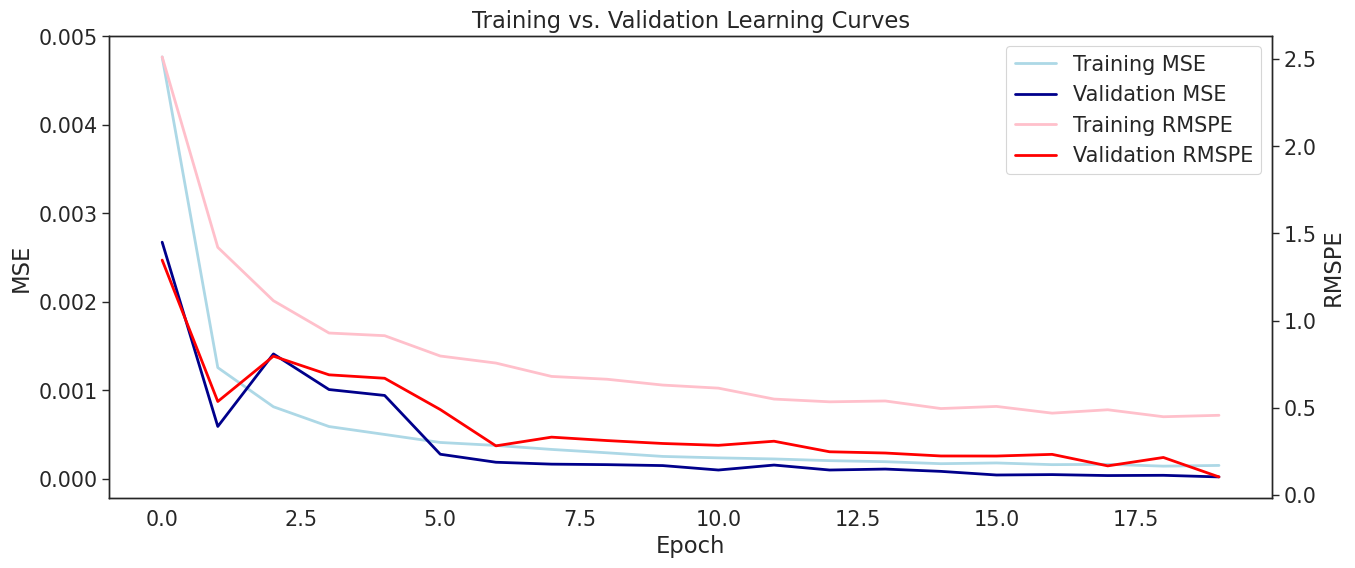

<Figure size 640x480 with 0 Axes>

In [ ]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_5_res)
plt.savefig('plots/plot11_lstm5_training_curves')

In [ ]:
# FORECASTING ON VALIDATION SET
lstm_5_preds = forecast_multi(lstm_5, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_5_preds_scaled = scale(scaler_vol, lstm_5_preds)

7/7 [==============================] - 0s 13ms/step


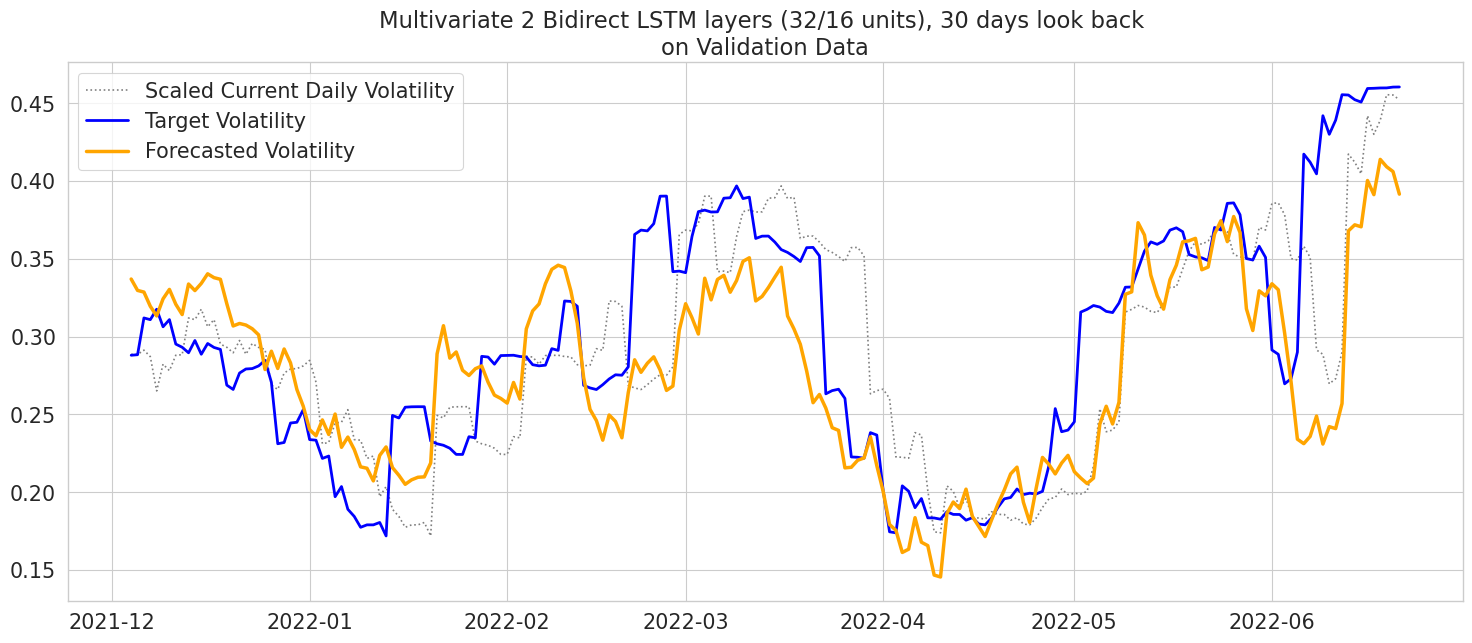

<Figure size 640x480 with 0 Axes>

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_5_preds_scaled, 
          f"Multivariate 2 Bidirect LSTM layers (32/16 units), {n_past} days look back")

plt.show();
plt.savefig('plots/plot12_lstm5_forecasted_validation')

The prediction line has moved horizontally more towards target lines, and has 


actually traced the desired output very closely between November 2020 to February 2021. This is certainly an improvement compared to all the previous model. It also doesn't look as noisy as some of the other ones.

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_5_preds_scaled,
         f"Multivariate Bidirect LSTM 2 layers (32/16 units), n_past={n_past}")

Model  Validation RMSPE  \
0            Simple LR Fully Connected NN, n_past=30          0.224265   
1                   LSTM 1 layer 20 units, n_past=30          0.172286   
2    2 layers Bidirect LSTM (32/16 units), n_past=30          0.175937   
3  1 Conv1D 2 Bidirect LSTM layers (32/16), n_pas...          0.214646   
4  2 Bidirect LSTMs (32/16), n_past=30, batch=64,...          0.276782   
5  Multivariate Bidirect LSTM 2 layers (32/16 uni...          0.164289   

   Validation RMSE  
0         0.059308  
1         0.050687  
2         0.050617  
3         0.056291  
4         0.076506  
5         0.055445

<img src="https://bluejaysnation.com/wp-content/uploads/sites/8/2019/09/im-not-crying-youre-crying.jpg " width="200" />

This is the first model with a Validation RMSPE sub 0.2, and it's actually almost 5% lower than the best model found above (Univariate LSTM with 2 layers). 

(I have also experimented with adding 1D convolutional layers to this Multivariate LSTM models, which is available in the Exploratory Notebooks folder, but it did not produce better results, so I am going to omit that version here).

### 4.8. Multivariate 3-Layered Bidirectional LSTM

Next, I'm going to add more LSTM layers to see if that helps improve performance.

In [ ]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_6 = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # normalize,
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(), 
    
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 3rd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),
    
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_6.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_6.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_6.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 30, 4)            16        
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 128)          35328     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 30, 64)           41216     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                        

In [ ]:
lstm_6_res = lstm_6.fit(mat_X_train, mat_y_train, epochs=20,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

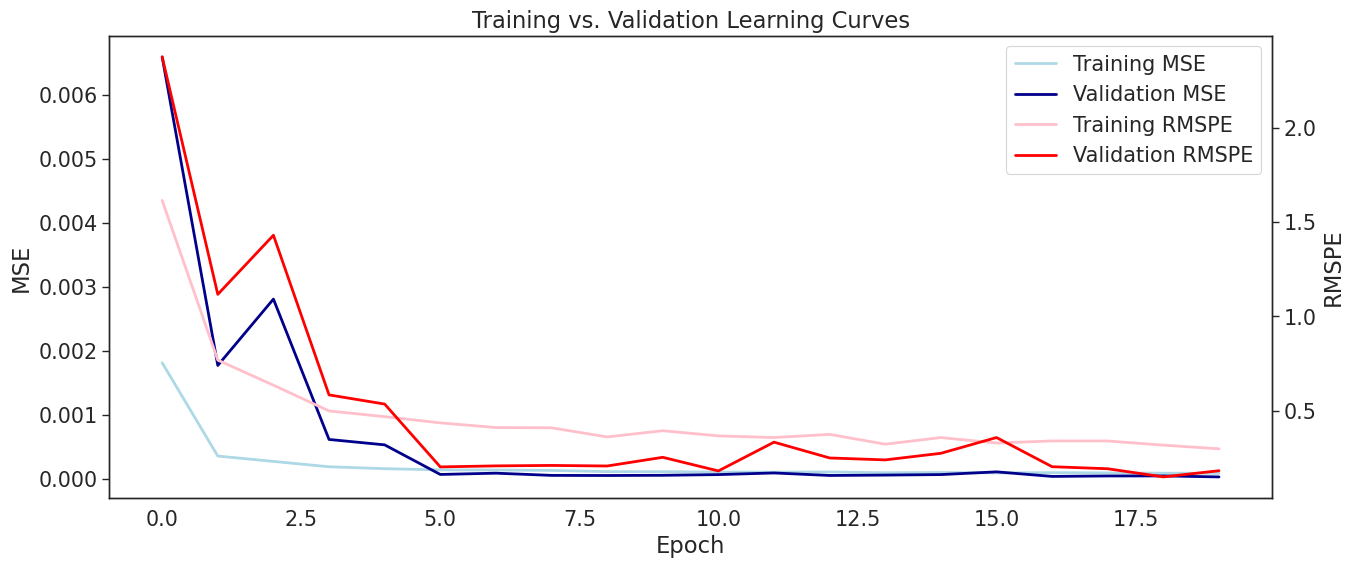

<Figure size 640x480 with 0 Axes>

In [ ]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_6_res)
plt.savefig('plots/plot13_lstm6_training_curves')

In [ ]:
# FORECASTING ON VALIDATION SET
lstm_6_preds = forecast_multi(lstm_6, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_6_preds_scaled = scale(scaler_vol, lstm_6_preds)

7/7 [==============================] - 3s 24ms/step


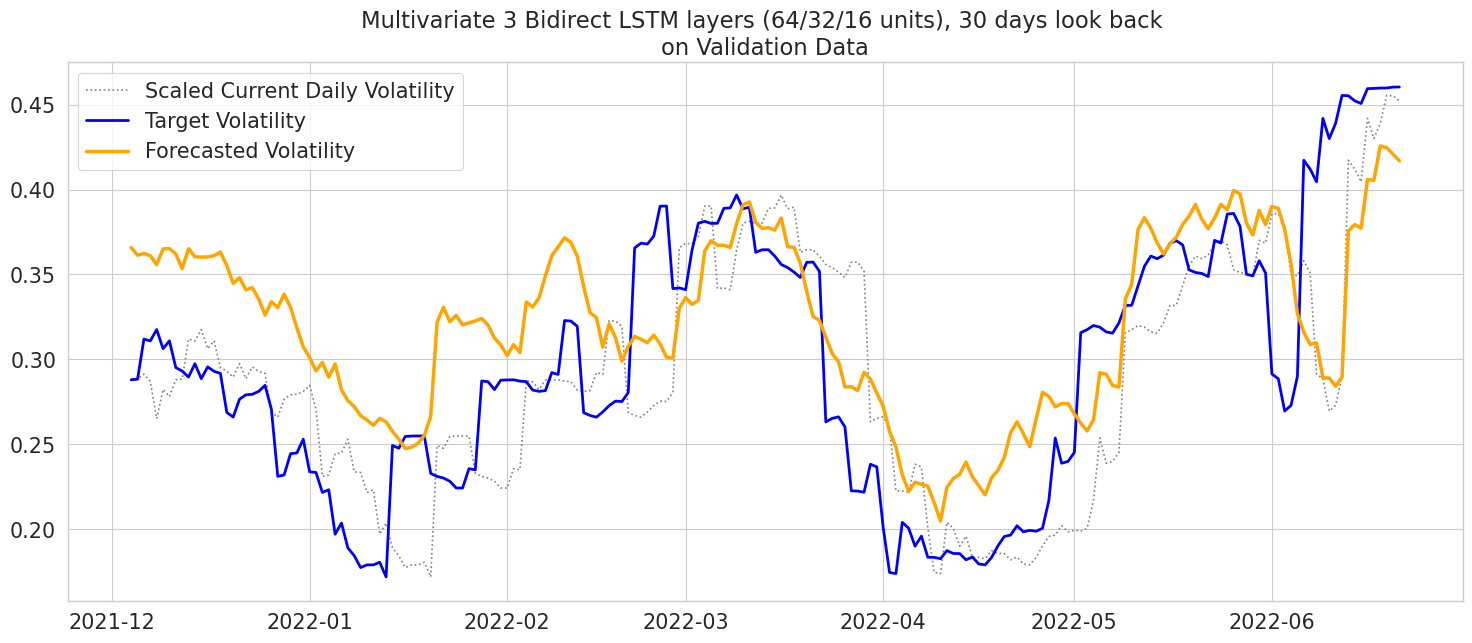

<Figure size 640x480 with 0 Axes>

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_6_preds_scaled, 
          f"Multivariate 3 Bidirect LSTM layers (64/32/16 units), {n_past} days look back")
plt.show();
plt.savefig('plots/plot14_lstm6_forcasted_validation')

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_6_preds_scaled,
         f"Multivariate Bidirect LSTM 3 layers (64/32/16 units), n_past={n_past}")

Model  Validation RMSPE  \
0            Simple LR Fully Connected NN, n_past=30          0.224265   
1                   LSTM 1 layer 20 units, n_past=30          0.172286   
2    2 layers Bidirect LSTM (32/16 units), n_past=30          0.175937   
3  1 Conv1D 2 Bidirect LSTM layers (32/16), n_pas...          0.214646   
4  2 Bidirect LSTMs (32/16), n_past=30, batch=64,...          0.276782   
5  Multivariate Bidirect LSTM 2 layers (32/16 uni...          0.164289   
6  Multivariate Bidirect LSTM 3 layers (64/32/16 ...          0.227662   

   Validation RMSE  
0         0.059308  
1         0.050687  
2         0.050617  
3         0.056291  
4         0.076506  
5         0.055445  
6         0.058778

Adding another LSTM layer helped reduce RMSE by a small margin (from 0.046139 to 0.044660), but RMSPE has actually gone up slightly (from 0.156677 to 0.164623).

### 4.8. Multivariate 4-Layered Bidirectional LSTM

In [ ]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_7 = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # BATCH NORMALIZATION  
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    # ADDING 3rd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    # ADDING 4th LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_7.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_7.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_7.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 30, 4)            16        
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 256)          136192    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 30, 128)          164352    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                        

In [ ]:
# FITTING TO TRAINING DATA
lstm_7_res = lstm_7.fit(mat_X_train, mat_y_train, epochs=20,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

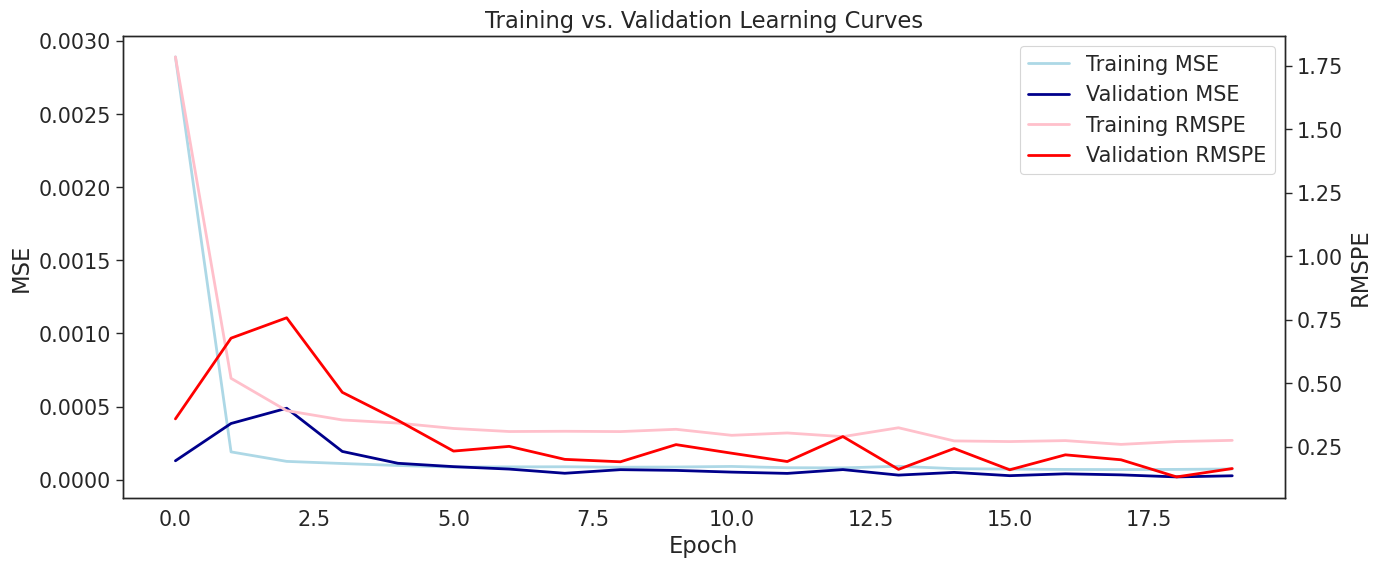

<Figure size 640x480 with 0 Axes>

In [ ]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_7_res)
plt.savefig('plots/plot15_lstm7_training_curves')

In [ ]:
# FORECASTING ON VALIDATION SET
lstm_7_preds = forecast_multi(lstm_7, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_7_preds_scaled = scale(scaler_vol, lstm_7_preds)

7/7 [==============================] - 5s 106ms/step


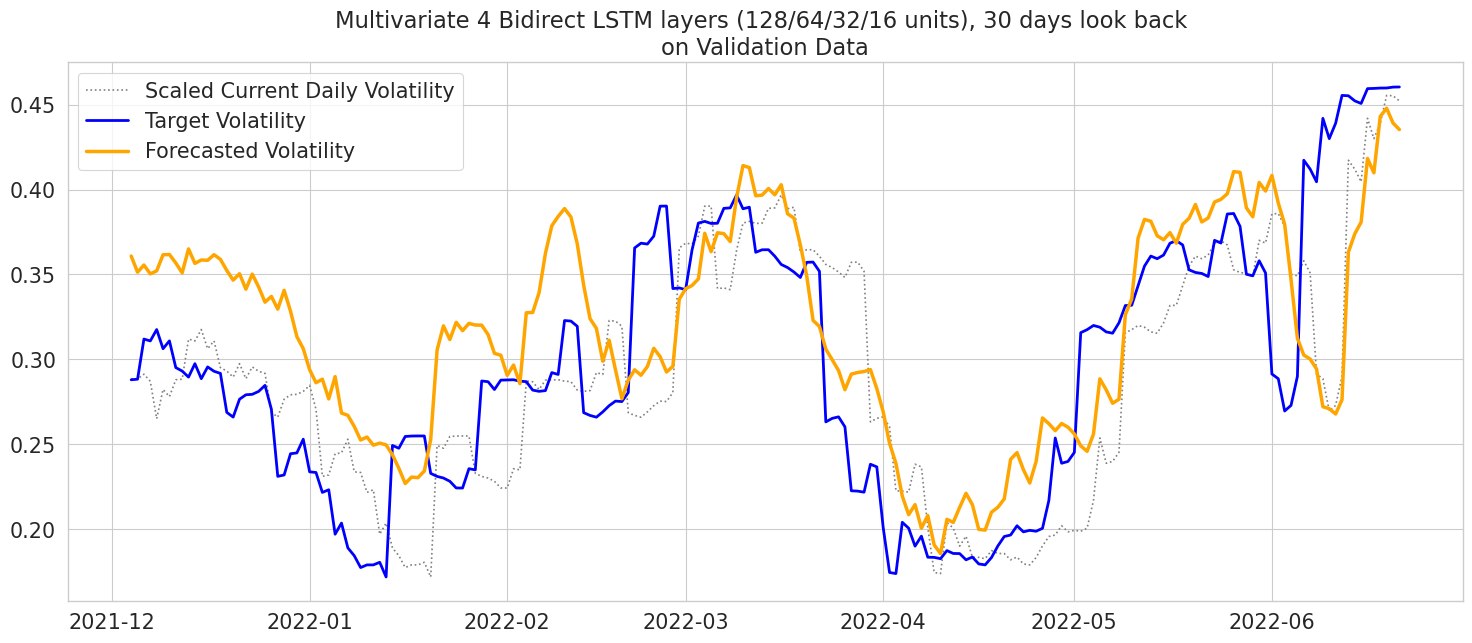

<Figure size 640x480 with 0 Axes>

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_7_preds_scaled, 
          f"Multivariate 4 Bidirect LSTM layers (128/64/32/16 units), {n_past} days look back")

plt.show();
plt.savefig('plots/plot16_lstm7_forecasted_validation')

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_7_preds_scaled, 
         f"Multivariate 4 Bidirect LSTM layers (128/64/32/16 units), n_past={n_past}, batch={batch_size}")

Model  Validation RMSPE  \
0            Simple LR Fully Connected NN, n_past=30          0.224265   
1                   LSTM 1 layer 20 units, n_past=30          0.172286   
2    2 layers Bidirect LSTM (32/16 units), n_past=30          0.175937   
3  1 Conv1D 2 Bidirect LSTM layers (32/16), n_pas...          0.214646   
4  2 Bidirect LSTMs (32/16), n_past=30, batch=64,...          0.276782   
5  Multivariate Bidirect LSTM 2 layers (32/16 uni...          0.164289   
6  Multivariate Bidirect LSTM 3 layers (64/32/16 ...          0.227662   
7  Multivariate 4 Bidirect LSTM layers (128/64/32...          0.212268   

   Validation RMSE  
0         0.059308  
1         0.050687  
2         0.050617  
3         0.056291  
4         0.076506  
5         0.055445  
6         0.058778  
7         0.058417

## **LSTM Network Tuning**

For this section, I will use the library `talos` to grid search various permutations for hyperparameter tunining just to make sure one more time that I am not missing anything potential. 

In [ ]:
def lstm_network(X_tr, y_tr, X_v, y_v, params):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]))

    # HIDDEN LAYERS
    for layer in range(params['lstm_layers'],1,-1):
        # FOR THE LAST LAYER - return_sequences NEEDS TO BE False
        # ALL OTHER LAYERS - returns_sequences = True
        seq = False if layer == 1 else True
        
        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(2**(layer+3),
                                                                     return_sequences=seq,
                                                                     activation=params['activation'])))
        model.add(tf.keras.layers.Dropout(params['dropout']))

    model.add(tf.keras.layers.Dense(1))

    # COMPILE
    model.compile(loss='mse', 
                  optimizer='adam', 
                  metrics=[rmspe])
    
    # STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
    early_stopping_cb = EarlyStopping(patience=3,
                                      restore_best_weights=True,
                                      monitor='val_rmspe')
    # FIT
    res = model.fit(X_tr, y_tr, 
                    validation_data=(X_v, y_v),
                    batch_size=params['batch_size'],
                    epochs=10,
                    verbose=0,
                    callbacks=[early_stopping_cb])
    
    return res, model

In [ ]:
params = {'dropout': [0.1, 0.2], 
          'activation': ['relu', 'tanh', 'sigmoid'], 
          'lstm_layers': [2,3,4],
          'batch_size': [32,64]}

In [ ]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

from_i = val_idx[0] - timedelta(n_past - 1)
to_i = val_idx[-1]
mat_X_val, mat_y_val = windowed_dataset(input_df[from_i:to_i], 
                                        df.vol_future[val_idx], n_past)

results = talos.Scan(x=mat_X_train, y=mat_y_train, 
                     x_val=mat_X_val, y_val=mat_y_val,
                     params=params, 
                     model=lstm_network,
                     experiment_name='grid',
                     reduction_metric='rmspe',
                     minimize_loss=True)

In [ ]:
results.data.sort_values(by='val_rmspe', ascending=True)[:3]

start              end    duration  round_epochs      loss  \
8   04/23/23-172435  04/23/23-172519   43.941149            10  0.000430   
32  04/23/23-174442  04/23/23-174525   43.303088            10  0.000563   
28  04/23/23-174048  04/23/23-174231  102.306159            10  0.000433   

       rmspe  val_loss  val_rmspe  dropout activation  lstm_layers  batch_size  
8   0.880030  0.000096   0.187978      0.1       tanh            3          32  
32  0.999607  0.000103   0.189068      0.2    sigmoid            3          32  
28  0.887254  0.000089   0.192095      0.2       tanh            4          32

In [ ]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 32
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_8 = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # normalize,
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,
                                                       activation='tanh')),
    tf.keras.layers.Dropout(0.1),

    # ADDING 3rd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='tanh')),
    tf.keras.layers.Dropout(0.1),
    
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_8.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_8.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_8.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 30, 4)            16        
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 64)           9472      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [ ]:
# FITTING TO TRAINING DATA
lstm_8_res = lstm_8.fit(mat_X_train, mat_y_train, epochs=20,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

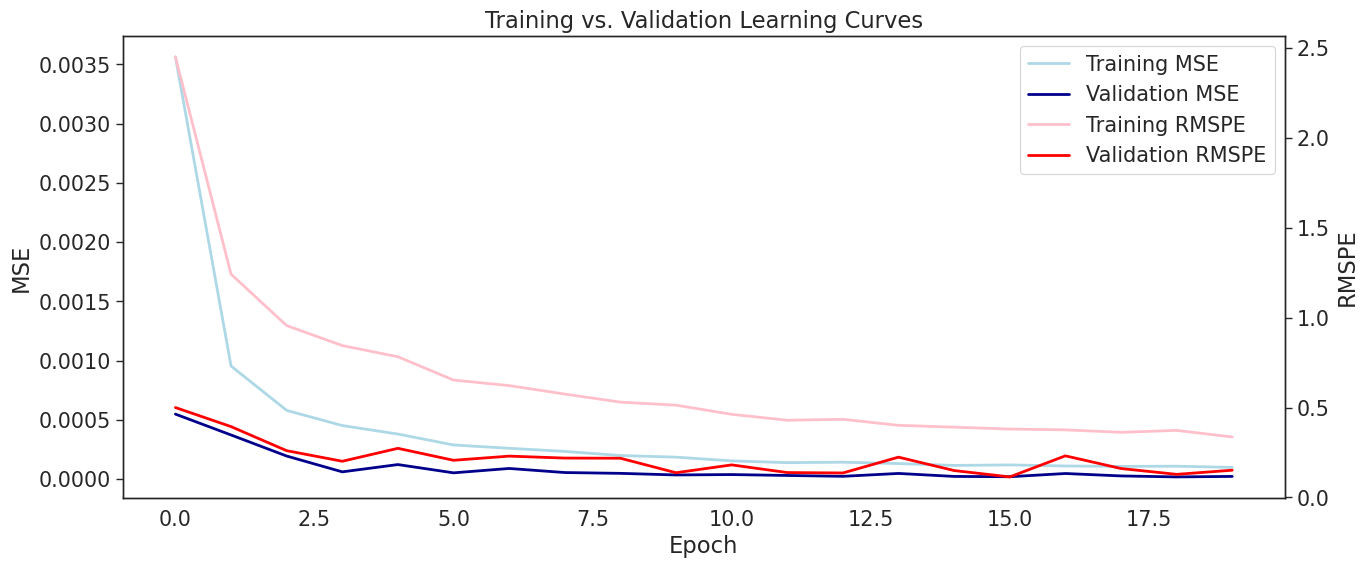

<Figure size 640x480 with 0 Axes>

In [ ]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_8_res)
plt.savefig('plots/plot17_lstm8_training_curves')

In [ ]:
# FORECASTING ON VALIDATION SET
lstm_8_preds = forecast_multi(lstm_8, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_8_preds_scaled = scale(scaler_vol, lstm_8_preds)

7/7 [==============================] - 2s 20ms/step


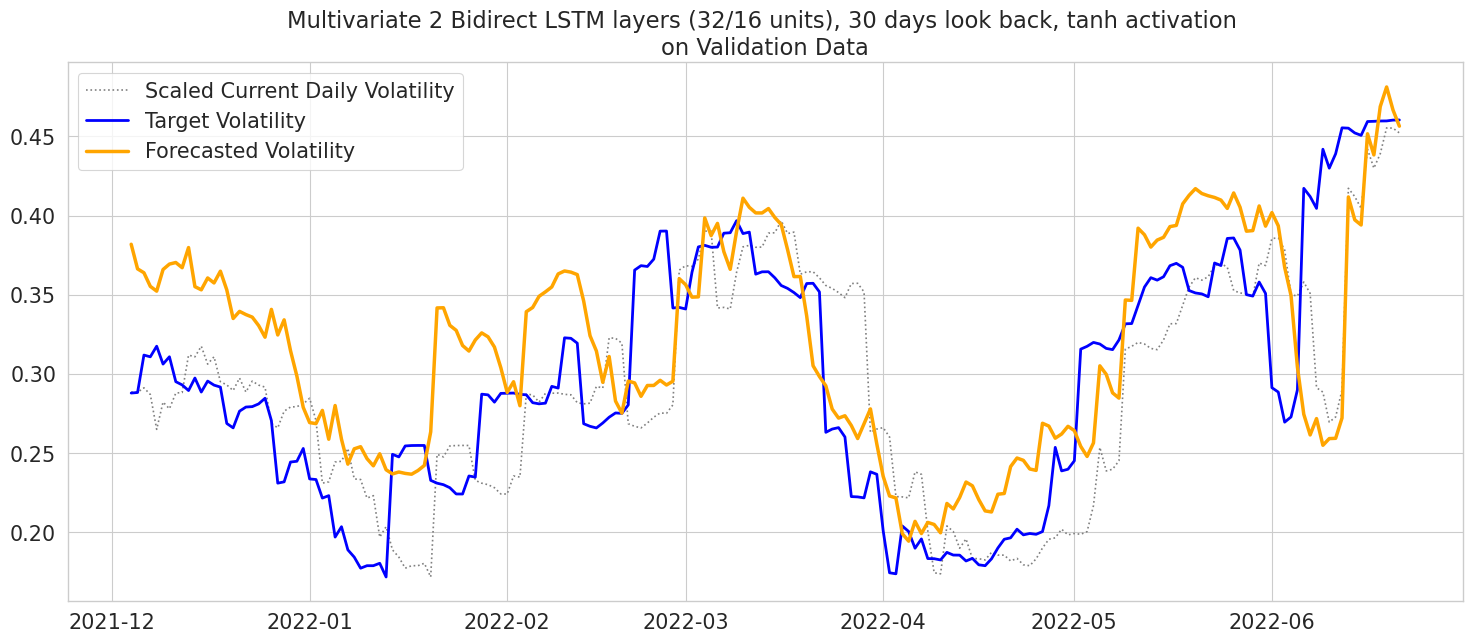

<Figure size 640x480 with 0 Axes>

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_8_preds_scaled, 
          f"Multivariate 2 Bidirect LSTM layers (32/16 units), {n_past} days look back, tanh activation")

plt.show();
plt.savefig('plots/plot18_lstm8_forecasted_valiation')

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_8_preds_scaled, 
         f"Multivariate 2 Bidirect LSTM layers (32/16 units), n_past={n_past}, batch={batch_size}, tanh")

Model  Validation RMSPE  \
0            Simple LR Fully Connected NN, n_past=30          0.224265   
1                   LSTM 1 layer 20 units, n_past=30          0.172286   
2    2 layers Bidirect LSTM (32/16 units), n_past=30          0.175937   
3  1 Conv1D 2 Bidirect LSTM layers (32/16), n_pas...          0.214646   
4  2 Bidirect LSTMs (32/16), n_past=30, batch=64,...          0.276782   
5  Multivariate Bidirect LSTM 2 layers (32/16 uni...          0.164289   
6  Multivariate Bidirect LSTM 3 layers (64/32/16 ...          0.227662   
7  Multivariate 4 Bidirect LSTM layers (128/64/32...          0.212268   
8  Multivariate 2 Bidirect LSTM layers (32/16 uni...          0.208539   

   Validation RMSE  
0         0.059308  
1         0.050687  
2         0.050617  
3         0.056291  
4         0.076506  
5         0.055445  
6         0.058778  
7         0.058417  
8         0.059011

## **Final Model**

In [ ]:
perf_df.sort_values(by='Validation RMSPE', ascending=True)

Model  Validation RMSPE  \
5  Multivariate Bidirect LSTM 2 layers (32/16 uni...          0.164289   
1                   LSTM 1 layer 20 units, n_past=30          0.172286   
2    2 layers Bidirect LSTM (32/16 units), n_past=30          0.175937   
8  Multivariate 2 Bidirect LSTM layers (32/16 uni...          0.208539   
7  Multivariate 4 Bidirect LSTM layers (128/64/32...          0.212268   
3  1 Conv1D 2 Bidirect LSTM layers (32/16), n_pas...          0.214646   
0            Simple LR Fully Connected NN, n_past=30          0.224265   
6  Multivariate Bidirect LSTM 3 layers (64/32/16 ...          0.227662   
4  2 Bidirect LSTMs (32/16), n_past=30, batch=64,...          0.276782   

   Validation RMSE  
5         0.055445  
1         0.050687  
2         0.050617  
8         0.059011  
7         0.058417  
3         0.056291  
0         0.059308  
6         0.058778  
4         0.076506

For this final model, I'll re-create the same architecture as model #12 (Multivariate Bidirectional LSTM with 2 layers of 32/16 units) and a lookback window `n_past = 30` and `batch_size = 64`. However, I'll extend the training to include the validation set as well. This is important in time series data since the more recent time steps would most likely carry more relevant information for successful forecasting than data from a year ago.

Since the validation MSE and RMSPE lines have been very unstable, I will extend the training epochs to 500 to seee if that could help capture better weights.

برای این مدل نهایی، همان معماری مدل 12 (Multivariate Bidirectional LSTM با 2 لایه 32/16 واحدی) و یک پنجره نگاه n_past = 30 و batch_size = 64 را دوباره ایجاد خواهم کرد. آموزش شامل مجموعه اعتبار سنجی نیز باشد. این در داده‌های سری زمانی مهم است، زیرا گام‌های زمانی اخیر به احتمال زیاد اطلاعات مرتبط‌تری را برای پیش‌بینی موفقیت‌آمیز نسبت به داده‌های یک سال پیش دارند.

از آنجایی که خطوط اعتبارسنجی MSE و RMSPE بسیار ناپایدار بوده اند، دوره های آموزشی را به 500 افزایش خواهم داد تا ببینم آیا این می تواند به گرفتن وزنه های بهتر کمک کند یا خیر.

In [ ]:
# CREATE DATASET THAT COMBINES BOTH TRAINING & VALIDATION
tv_df = input_df[:split_time_2]
tv_y = df.vol_future[:split_time_2]

In [ ]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_tv, mat_y_tv = windowed_dataset(tv_df, tv_y, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_final = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),   
    # BATCH NORMALIZATION  
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_final.compile(loss='mse', 
                    optimizer="adam", 
                    metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_final.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_final.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 30, 4)            16        
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 64)           9472      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [ ]:
lstm_final_res = lstm_final.fit(mat_X_tv, mat_y_tv, epochs=500,
                                validation_split=0.2,
                                callbacks=[checkpoint_cb, early_stopping_cb],
                                verbose=0, batch_size=batch_size, shuffle=True)

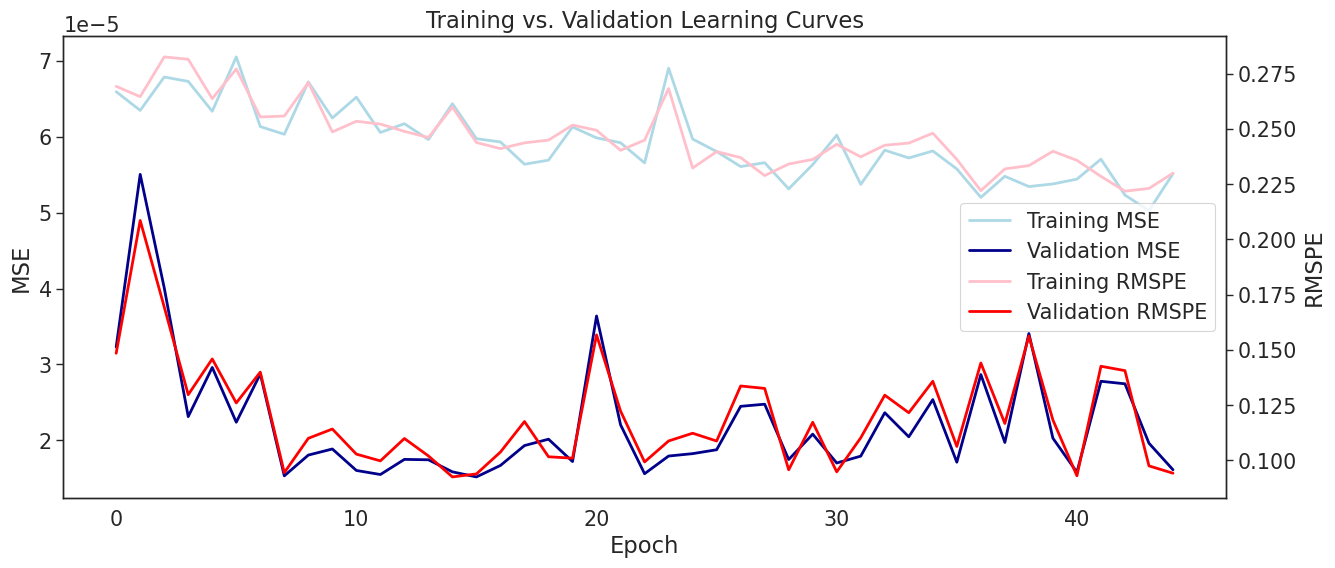

<Figure size 640x480 with 0 Axes>

In [ ]:
viz_train_val_metrics(lstm_final_res)
plt.savefig('plot19_lstm_final_training_curves')

### Final Model's Predictions on Test Set

In [ ]:
# FORECASTING ON VALIDATION SET
y_test_preds = forecast_multi(lstm_final, test_idx)

10/10 [==============================] - 0s 15ms/step


In [ ]:
y_test_preds.describe()

count    300.000000
mean       0.030316
std        0.008540
min        0.015797
25%        0.025124
50%        0.029259
75%        0.035397
max        0.051843
dtype: float64

In [ ]:
y_test.describe()

count    300.000000
mean       0.029289
std        0.009302
min        0.013625
25%        0.022493
50%        0.028674
75%        0.034829
max        0.049949
Name: vol_future, dtype: float64

In [ ]:
# GETTING DAILY VOLATILITY QUANTILES
q1 = df.vol_current[:split_time_2].describe()['25%']

q2 = df.vol_current[:split_time_2].describe()['50%']

q3 = df.vol_current[:split_time_2].describe()['75%']

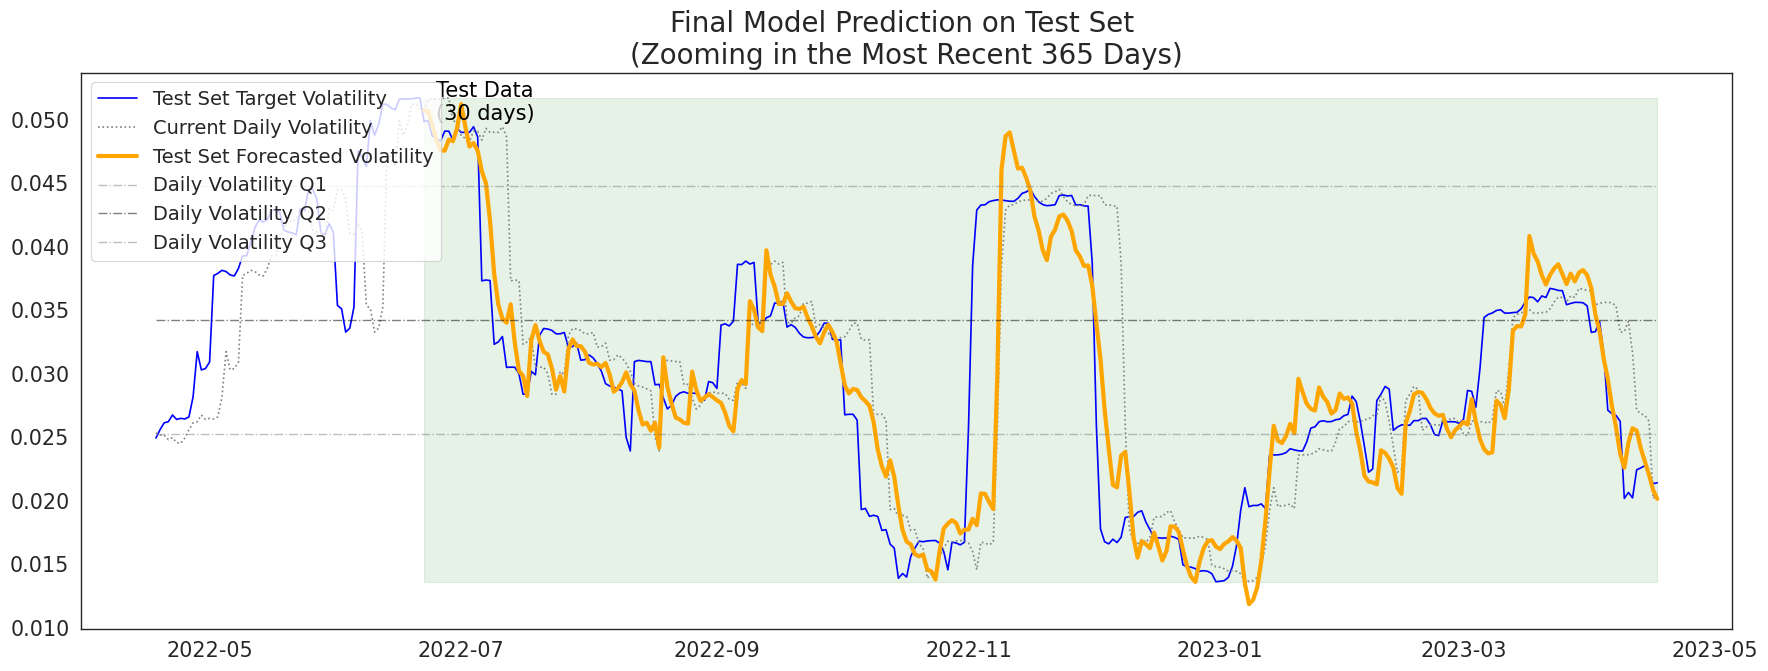

<Figure size 640x480 with 0 Axes>

In [ ]:
# Ref: https://stackoverflow.com/questions/31162780/how-to-plot-a-rectangle-on-a-datetime-axis-using-matplotlib

# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
with sns.axes_style("white"):
    fig, ax1 = plt.subplots(figsize=(18,7))
    # ZOOMING IN THE LAST n_display VALUES
    n_display = 365

    ax1.plot(df.vol_future[-n_display:], color='blue', 
                label=f"Test Set Target Volatility")
    ax1.plot(df.vol_current[-n_display:], color='gray',  ls=':',
                label=f"Current Daily Volatility")
    ax1.plot(y_test_preds, color='orange', lw=3,
                label=f'Test Set Forecasted Volatility')
    
    q_colors = ['gray', 'black', 'gray']
    for i, q in enumerate([q1, q2, q3]):
        ax1.hlines(y=q, color=q_colors[i], alpha=0.5, label=f'Daily Volatility Q{i+1}', ls='-.', lw=1,
                    xmin=df.vol_future[-n_display:].index[0],
                    xmax=df.vol_future[-n_display:].index[-1])
        
    # ADD RECTANGLE TO PLOT AS BACKGROUND FOR TEST DATA    
    w = len(test_idx) - 1 
    h = df.vol_future[-n_display:].max() - df.vol_future[-n_display:].min()
    x0 = mdates.date2num(df.index[split_time_2])
    y0 = df.vol_future[-n_display:].min()
    rect = Rectangle((x0, y0), w, h, color ='green', alpha=0.1)
    ax1.add_patch(rect)

    # ADD TEXT
    ax1.text(df.index[(split_time_2 + 3)], 0.05, 
             'Test Data\n(30 days)', 
             fontsize=15, color='black')

    plt.title(f'Final Model Prediction on Test Set \n(Zooming in the Most Recent {n_display} Days)', fontsize=20)
    ax1.legend(loc='upper left', prop={'size': 14})
    plt.tight_layout()
    plt.show();
    plt.savefig('plots/plot20_final_model_prediction_on_testset')

In [ ]:
# GENERATING PREDICTIONS ON THE WHOLE DATASET (7 years)
mat_X_all, _ = windowed_dataset(input_df, df.vol_future, n_past)
preds_all = pd.Series(lstm_final.predict(mat_X_all)[:,0], 
                      index=df.index[-(mat_X_all).shape[0]:])

97/97 [==============================] - 1s 15ms/step


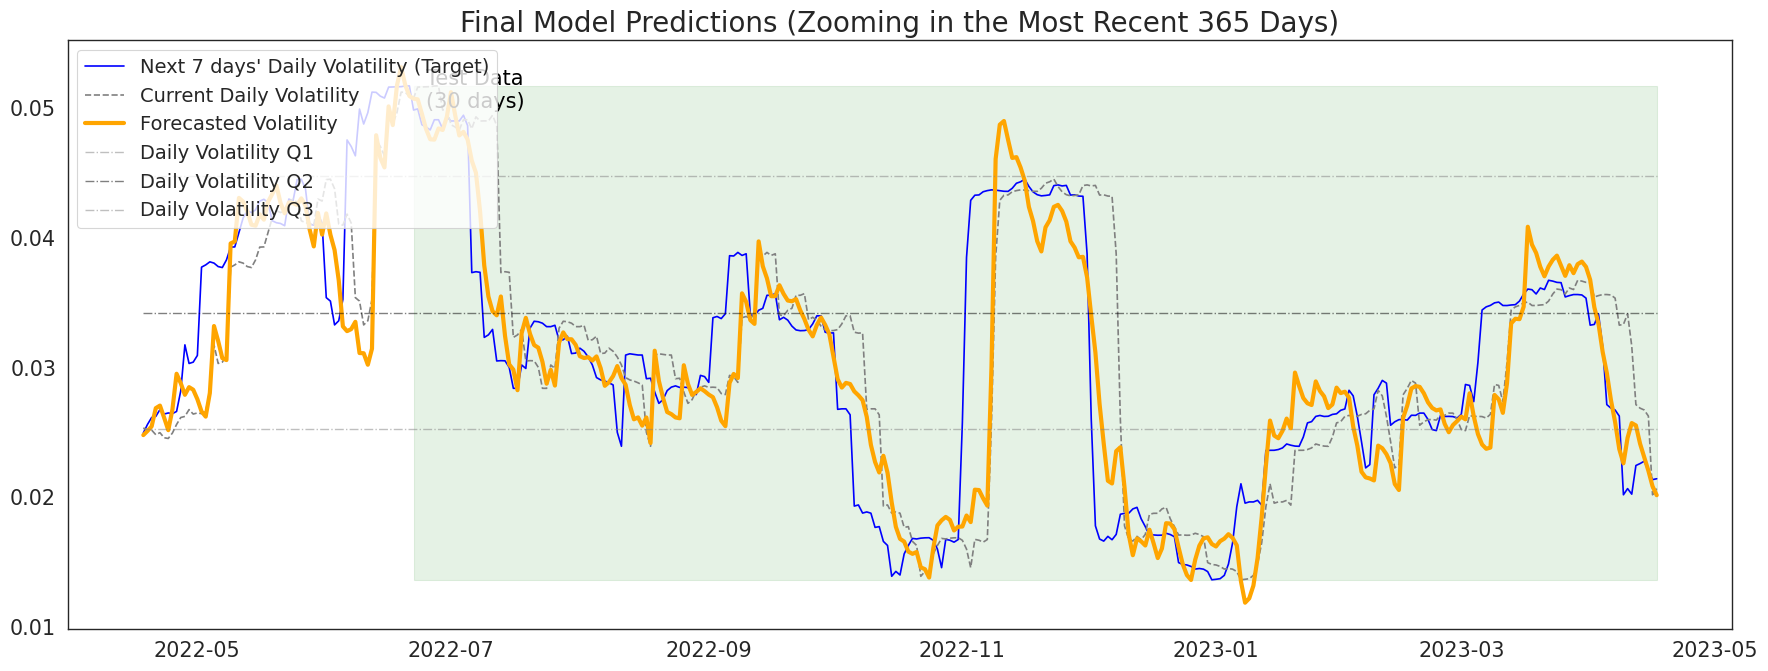

<Figure size 640x480 with 0 Axes>

In [ ]:
# Ref: https://stackoverflow.com/questions/31162780/how-to-plot-a-rectangle-on-a-datetime-axis-using-matplotlib
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
with sns.axes_style("white"):
    fig, ax1 = plt.subplots(figsize=(18,7))
    # ZOOMING IN THE LAST n_display VALUES
    n_display = 365

    ax1.plot(df.vol_future[-n_display:], color='blue', 
                label=f"Next {n_future} days' Daily Volatility (Target)")
    ax1.plot(df.vol_current[-n_display:], color='gray',  ls='--',
                label=f"Current Daily Volatility")
    ax1.plot(preds_all[-n_display:], color='orange', lw=3,
                label=f'Forecasted Volatility')

    q_colors = ['gray', 'black', 'gray']
    for i, q in enumerate([q1, q2, q3]):
        ax1.hlines(y=q,
                   xmin=df.vol_future[-n_display:].index[0],
                   xmax=df.vol_future[-n_display:].index[-1],
                   label=f'Daily Volatility Q{i+1}',
                   ls='-.', lw=1, color=q_colors[i], alpha=0.5)
    
    # ADD RECTANGLE TO PLOT AS BACKGROUND FOR TEST DATA    
    w = len(test_idx) - 1 
    h = df.vol_future[-n_display:].max() - df.vol_future[-n_display:].min()
    x0 = mdates.date2num(df.index[split_time_2])
    y0 = df.vol_future[-n_display:].min()
    rect = Rectangle((x0, y0), w, h, color ='green', alpha=0.1)
    ax1.add_patch(rect)

    # ADD TEXT
    ax1.text(df.index[(split_time_2 + 3)], 0.05, 
             'Test Data\n(30 days)', 
             fontsize=15, color='black')

    plt.title(f'Final Model Predictions (Zooming in the Most Recent {n_display} Days)', fontsize=20)
    ax1.legend(loc='upper left', prop={'size': 14})
    plt.tight_layout()
    plt.show();
    plt.savefig('plots/plot21_final_model_predictions')

It should be stressed that the model was trained on both the training and validation data this time. Therefore it'd naturally trace the target more closely up until the third week of July 2021 where the validation ends. 

In [ ]:
perf_df.to_pickle("performance_df.pkl")

In [ ]:
print('RMSPE on Test Set:', RMSPE(y_test, y_test_preds))

RMSPE on Test Set: 0.17016901362983688


In [ ]:
1-RMSPE(y_test, y_test_preds)

0.8298309863701632

# **Conclusion**

In terms of performance on the validation set (7/23/2020 to 7/25/2021), my final LSTM model has an RMSPE of 0.156677, which is roughly 4.42% better than the best performing variant of the GARCH models found - TARCH(1,2) with an RMSPE of 0.200954. Traders does not need to make perfectly accurate forecast to have a positive expectation when participating in the markets, they just need to make a forecast that is **both correct and more correct than the general consensus**. With GARCH still being the most popular volatility forecasting model, Multivariate LSTM could potentially give investors an advantage in terms of higher forecasting accuracy.

The final LSTM model has an RMSPE of 0.0534 on the Test set (which is the most recent 30 days of which future volatility data is available for comparison). Since RMSPE indicates the average magnitude of the error in relation to the actual values, an RMSPE of 0.0534 would translate to a magnitude accuracy of 94.65% on the average 7-day horizon daily volatility forecasting within the period of 07/24/2021 to 08/22/2021.  

However, since financial time series data are constantly evolving, no model would be able to consistently forecast with high accuracy level forever. The average lifetime of a model is between 6 months to 5 years, and there's a phenomenon in quant trading that is called **alpha decay**, which is the loss in predictive power of an alpha model over time. In addition, according to Sinclair (2020), researchers have found that the publication of a new "edge" or anomaly in the markets lessens its returns by up to 58%.  

These models therfore require constant tweaking and tuning based on the most recent information available to make sure they stay up-to-date and learn to evolve with the markets. 

نتیجه
از نظر عملکرد در مجموعه اعتبارسنجی (2020/7/23 تا 2021/7/25)، مدل نهایی LSTM من دارای RMSPE 0.156677 است که تقریباً 4.42٪ بهتر از بهترین عملکرد مدل های GARCH یافت شده - TARCH است. (1،2) با RMSPE 0.200954. معامله گران برای داشتن انتظارات مثبت در هنگام حضور در بازارها نیازی به پیش بینی کاملا دقیق ندارند، آنها فقط باید پیش بینی درست و صحیح تر از اجماع عمومی انجام دهند. با توجه به اینکه GARCH همچنان محبوب‌ترین مدل پیش‌بینی نوسان است، LSTM چند متغیره می‌تواند به طور بالقوه مزیتی را از نظر دقت پیش‌بینی بالاتر به سرمایه‌گذاران بدهد.

مدل نهایی LSTM دارای RMSPE 0.0534 در مجموعه تست است (که آخرین 30 روز است که داده های نوسانات آینده برای مقایسه در دسترس است). از آنجایی که RMSPE میانگین بزرگی خطا را در رابطه با مقادیر واقعی نشان می‌دهد، RMSPE 0.0534 به دقت بزرگی 94.65٪ در میانگین پیش‌بینی نوسانات روزانه افق 7 روزه در دوره 24/07/2021 تا 08 ترجمه می‌شود. /22/2021.

با این حال، از آنجایی که داده‌های سری زمانی مالی به طور مداوم در حال تغییر هستند، هیچ مدلی قادر به پیش‌بینی مداوم با سطح دقت بالا برای همیشه نخواهد بود. میانگین طول عمر یک مدل بین 6 ماه تا 5 سال است و پدیده ای در معاملات کوانتی وجود دارد که به آن واپاشی آلفا می گویند، که عبارت است از از دست دادن قدرت پیش بینی یک مدل آلفا در طول زمان. علاوه بر این، طبق گفته سینکلر (2020)، محققان دریافته اند که انتشار یک "لبه" یا ناهنجاری جدید در بازارها بازده آن را تا 58٪ کاهش می دهد.

بنابراین، این مدل‌ها بر اساس جدیدترین اطلاعات موجود نیاز به تغییر و تنظیم مداوم دارند تا مطمئن شوید که به‌روز می‌مانند و یاد می‌گیرند که با بازارها تکامل پیدا کنند.

# References:

1. Géron, A. (2019). *In Hands-on machine learning with Scikit-Learn & TensorFlow: concepts, tools, and techniques to build intelligent systems.* O'Reilly Media, Inc.

2. Sinclair, E. (2020). *Positional option trading: An advanced guide.* John Wiley &amp; Sons. 

3. https://algotrading101.com/learn/yfinance-guide/ 

4. https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/supplement/DM4fi/convolutional-neural-networks-course

5. https://insights.deribit.com/options-course/

6. https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html 

7. https://www.investopedia.com/terms/v/vix.asp 

8. https://www.hindawi.com/journals/complexity/2021/6647534/ 

9. https://github.com/ritvikmath/Time-Series-Analysis/blob/master/GARCH%20Stock%20Modeling.ipynb

10. https://github.com/ritvikmath/Time-Series-Analysis/blob/master/GARCH%20Model.ipynb

11. https://www.kaggle.com/c/optiver-realized-volatility-prediction 

12. https://www.youtube.com/watch?v=NKHQiN-08S8

13. https://goldinlocks.github.io/ARCH_GARCH-Volatility-Forecasting/ 

14. https://towardsdatascience.com/time-series-analysis-on-multivariate-data-in-tensorflow-2f0591088502 

15. https://deepmind.com/blog/article/wavenet-generative-model-raw-audio 

16. https://github.com/philipperemy/keras-tcn 

17. http://users.metu.edu.tr/ozancan/ARCHGARCHTutorial.html

18. https://towardsdatascience.com/8-commonly-used-pandas-display-options-you-should-know-a832365efa95